<img src="img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Module 7</font></h2>



<h1><font color="#00586D" size=5>Capstone 7. Part 2: Electricity Demand Forecast</font></h1>

<br><br><br>
<div style="text-align: right">
<font color="#00586D" size=3>Enrique González, Luis de la Ossa</font><br>
<font color="#00586D" size=3>Master in Data Science and Data Engineering in the Cloud I </font><br>
<font color="#00586D" size=3>University of Castilla-La Mancha</font>

</div>

---

<a id="indice"></a>
<h2><font color="#00586D" size=5>Index</font></h2>


*[1. Creating the forecast model](#section1)* [2. Intake and forecast display](#section2)

In [218]:
import matplotlib.pyplot as plt
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Optimiza los gráficos para pantalla retina
%config InlineBackend.figure_format = 'retina'
# Por defecto usamos el backend inline
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

# La libreta ocupa así el 95% de la pantalla
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In the next part of the capstone you will create a forecast model from the data ingested in InfluxDB and add the forecast to a day view back to InfluxDB so that the prototyped system can see the forecast for the day. Specifically, to create the model you will use data up to the last full day of data and the forecast will include the next day (which may or may not have data in our system, but we will not use it for training).

---

<a id="section1"></a>
## <font color="#00586D"> 1. Creating the forecast model</font>
<br>

To create the forecast model, we will need to download the data from our instance so we can have data to train with.


--- 

### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i> Task 1</font>
<br>

Implement the following function that returns a DataFrame with all the available electrical demand data stored in your InfluxDB instance. We are only interested in the actual demand series, so you will have to filter the electricity grid forecast using Flux.

You will need to add the authentication information for your InfluxDB instance below.

_Hint_: The InfluxDB practice that we did in this module will be useful for you to be able to form the query.

In [219]:
token = "mcidaen_token"
org = "mcidaen"
bucket = "capstone7"

client = InfluxDBClient(url="http://influxdb:8086", token=token)

In [220]:
query_client = client.query_api()

In [221]:
def load_from_influxdb(client: InfluxDBClient, bucket: str, org: str) -> pd.DataFrame:
    """
    Escribe el DataFrame en InfluxDB
    """
    
    ######## Solución: Guarda el resultado de la consulta en df
    query = (
    f'from(bucket: "{bucket}")'
    f'  |> range(start: 2022-02-01T10:00:00Z, stop: 2023-07-30T12:00:00Z)'
    f'  |> filter(fn: (r) => r._field == "RealDemand")'
    )
    df = query_client.query_data_frame(query, org=org)
    ###
    
    df_query = df.loc[:, ['_time', '_value']]
    df_query['datetime'] = pd.to_datetime(df_query['_time'], utc=True).dt.tz_localize(None)
    df_query['RealDemand'] = df_query['_value']
    df_query = df_query[['datetime', 'RealDemand']]
    df_query.index = df_query['datetime']
    #df_query['RealDemand'] = df_query['RealDemand'].sort_index()
    return df_query[['RealDemand']].sort_index()

In [222]:
df = load_from_influxdb(client, bucket, org)
df['2022'].sample(20, random_state=0)

RealDemand
datetime                         
2022-02-22 15:00:00  29644.000000
2022-07-26 06:00:00  30637.750000
2022-07-03 17:00:00  25946.250000
2022-12-12 08:00:00  32038.416667
2022-06-14 18:00:00  33918.333333
2022-02-16 06:00:00  30794.666667
2022-08-22 23:00:00  24990.500000
2022-03-02 06:00:00  29315.166667
2022-07-05 11:00:00  34285.833333
2022-04-23 21:00:00  24535.666667
2022-03-28 22:00:00  24334.166667
2022-11-01 00:00:00  19775.416667
2022-11-24 12:00:00  30743.416667
2022-08-29 10:00:00  32549.583333
2022-04-07 05:00:00  29485.000000
2022-04-02 23:00:00  22415.500000
2022-02-03 01:00:00  24210.166667
2022-03-22 02:00:00  21481.500000
2022-07-07 06:00:00  28856.833333
2022-11-08 04:00:00  21228.250000

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

--- 

With this data, the objective is to create a forecasting model that allows us to forecast hourly energy demand one day in advance. Although you can use the model you want (as long as it works with the rest of the components), in this case we have chosen to create a Prophet model.

To facilitate its integration with the rest of the code and to be able to run the model to forecast several days, we will create a function that trains the model and makes a forecast for a test set. To do this, we will create a model capable of forecasting, given a history, the hourly energy demand for the day following the history.


--- 

### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i> Task 2</font>
<br>

Implements the following function that, given the previous demand time series, _training_ and a list of timestamps, _test_:
- Train a Prophet model with the data from _training_
- Predict the hours spent in _test_

You can assume that the data set is in the output format of the function from the previous task.

Optional: As optional work, you can try several of the models presented during the module to see if you can obtain a better result. This will be taken into account when evaluating the capstone.

In [223]:
!pip install prophet

In [224]:
import datetime
from prophet import Prophet

def train_forecast(training: pd.DataFrame, test: list) -> pd.DataFrame:
    """
    Entrena con training y pronostica los datos de test
    """
    
    ######## Solución

    training = training.reset_index().rename(columns={'datetime': 'ds', 'RealDemand': 'y'})
    #test = pd.DataFrame(test, columns = ["datetime"]).rename(columns={'datetime': 'ds'})
    test = pd.DataFrame(test).set_axis(['ds'], axis=1)
    m = Prophet()
    m.fit(training)
    forecast = m.predict(test)
    
    return forecast[['ds', 'yhat']].rename(columns={'ds': 'datetime'}).set_index("datetime")
    #########

In [225]:
test = list(pd.date_range(start=datetime.datetime(2023, 2, 24), freq='H', periods=24))

In [226]:
result = train_forecast(df[:datetime.datetime(2023, 2, 24)], test)

22:21:14 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing


In [227]:
result

yhat
datetime                         
2023-02-24 00:00:00  26473.279550
2023-02-24 01:00:00  25734.456331
2023-02-24 02:00:00  25335.748659
2023-02-24 03:00:00  25484.229126
2023-02-24 04:00:00  26440.902272
2023-02-24 05:00:00  28153.532397
2023-02-24 06:00:00  30135.973459
2023-02-24 07:00:00  31756.119413
2023-02-24 08:00:00  32677.323985
2023-02-24 09:00:00  33035.072073
2023-02-24 10:00:00  33190.765897
2023-02-24 11:00:00  33326.014339
2023-02-24 12:00:00  33295.306067
2023-02-24 13:00:00  32881.807026
2023-02-24 14:00:00  32174.125221
2023-02-24 15:00:00  31637.360909
2023-02-24 16:00:00  31747.654680
2023-02-24 17:00:00  32509.747196
2023-02-24 18:00:00  33330.720050
2023-02-24 19:00:00  33413.422777
2023-02-24 20:00:00  32349.731653
2023-02-24 21:00:00  30402.730149
2023-02-24 22:00:00  28253.546142
2023-02-24 23:00:00  26475.701936

### Optional Part
<br>

ARIMA model

In [228]:
training = df[:datetime.datetime(2023, 2, 24)]
#test = pd.DataFrame(test).set_axis(['ds'], axis=1).set_index("ds")
test = df[datetime.datetime(2023, 2, 24):datetime.datetime(2023, 2, 28)]

Using the graph provided by influxdb, we see that it may be a stationary series: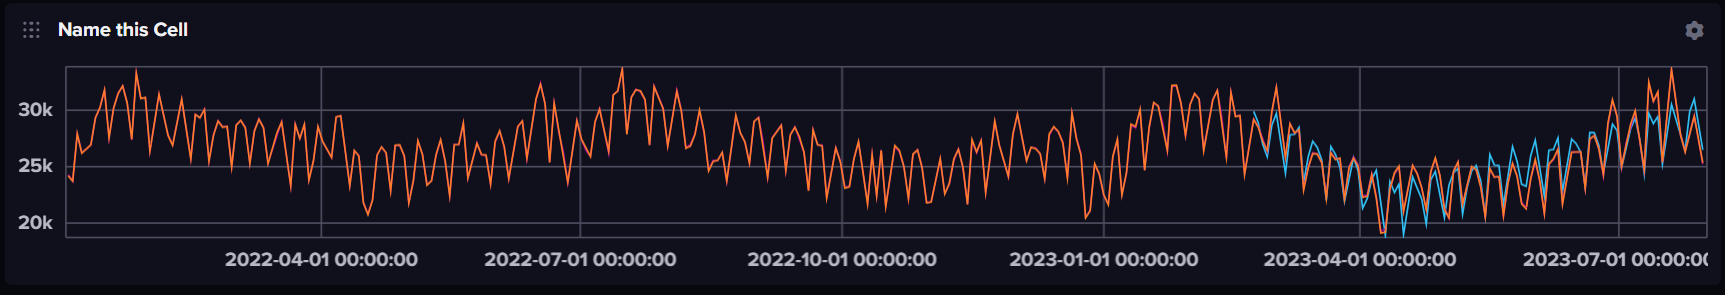

In [229]:
#training_1d = (training - training.shift(24))
#training_1d.plot(figsize=(20,5), color='firebrick')

We use the Dickey-Fuller test to check if it is stationary

In [230]:
from statsmodels.tsa.stattools import adfuller
adfuller(training.fillna(method='bfill'))[1]

6.125693499022618e-17

The p-value is less than 0.05, so the null hypothesis is rejected and we can say that it is stationary, since we have not had to apply differences, d=0. We find the autocorrelation:

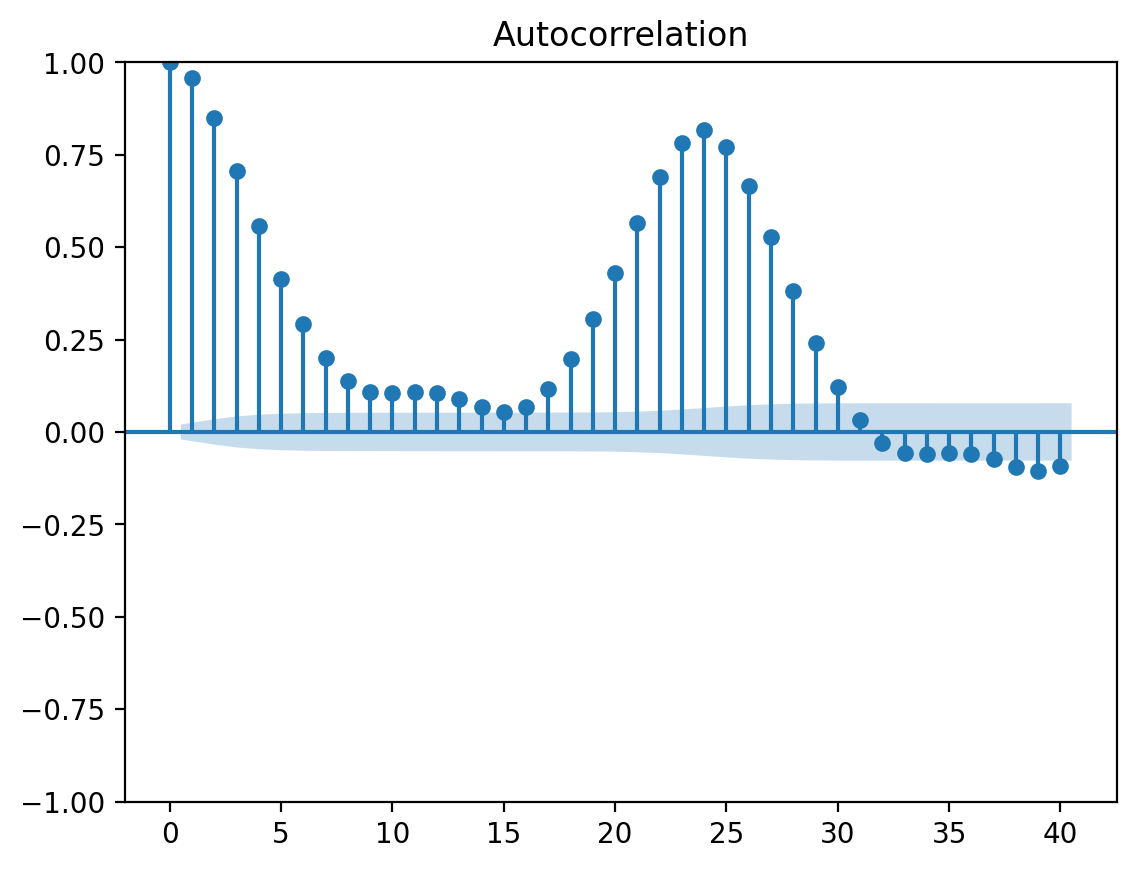

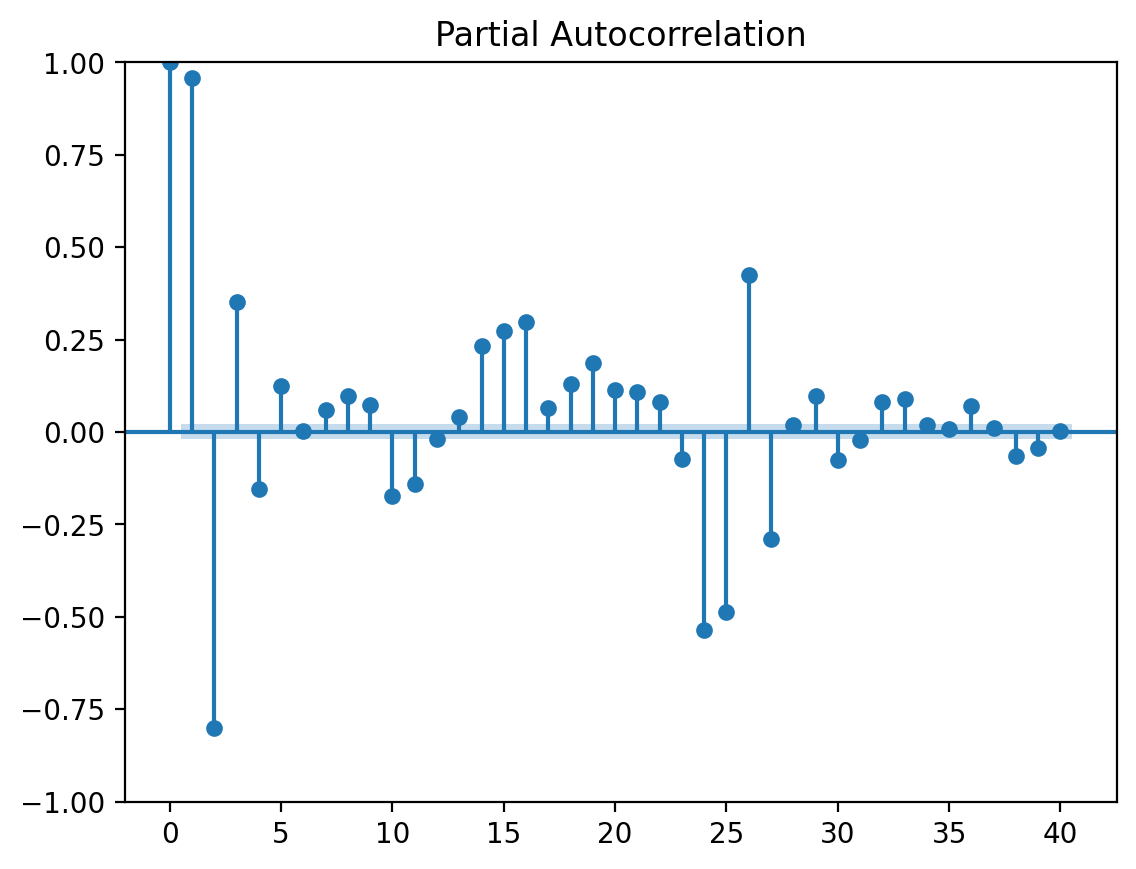

In [231]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(training.fillna(method='bfill'));
plot_pacf(training.fillna(method='bfill'));

We observe the correlation graph decreases gradually, while the autocorrelation graph decreases suddenly for k=3, so p = 3 and therefore we have ARIMA(3,0,0)

In [232]:
from statsmodels.tsa.arima.model import ARIMA
params = (3,0,0)
m = ARIMA(training, order=params)
result = m.fit()
prediction = pd.Series(result.forecast(len(test))[0], index=test.index)

In [233]:
prediction

datetime
2023-02-24 00:00:00    23368.199374
2023-02-24 01:00:00    23368.199374
2023-02-24 02:00:00    23368.199374
2023-02-24 03:00:00    23368.199374
2023-02-24 04:00:00    23368.199374
                           ...     
2023-02-27 20:00:00    23368.199374
2023-02-27 21:00:00    23368.199374
2023-02-27 22:00:00    23368.199374
2023-02-27 23:00:00    23368.199374
2023-02-28 00:00:00    23368.199374
Length: 97, dtype: float64

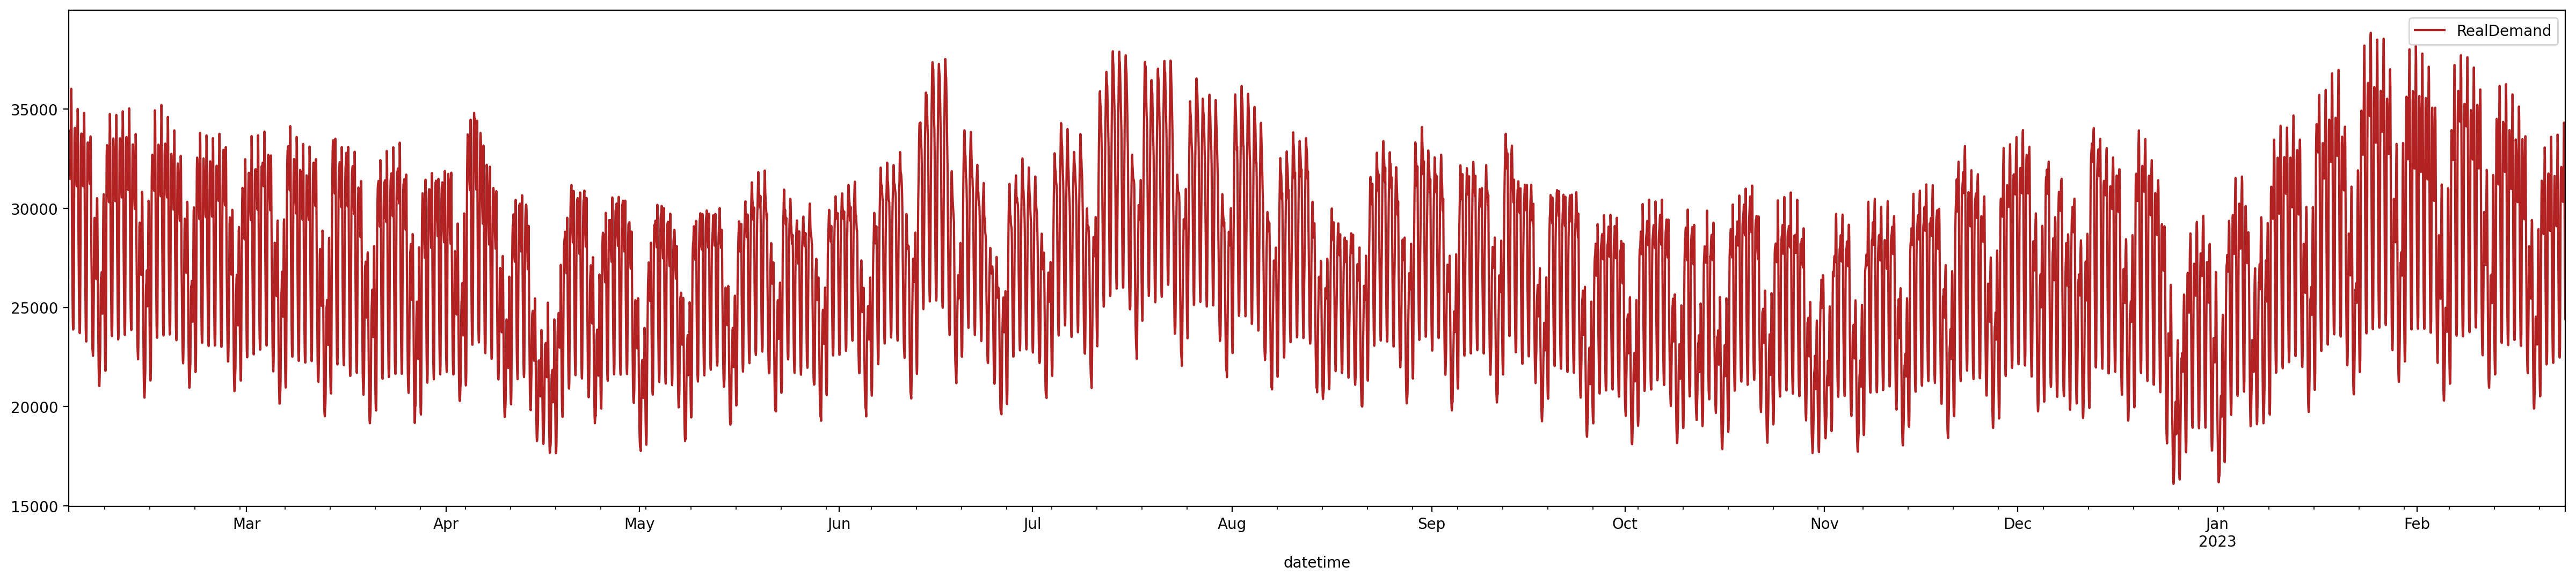

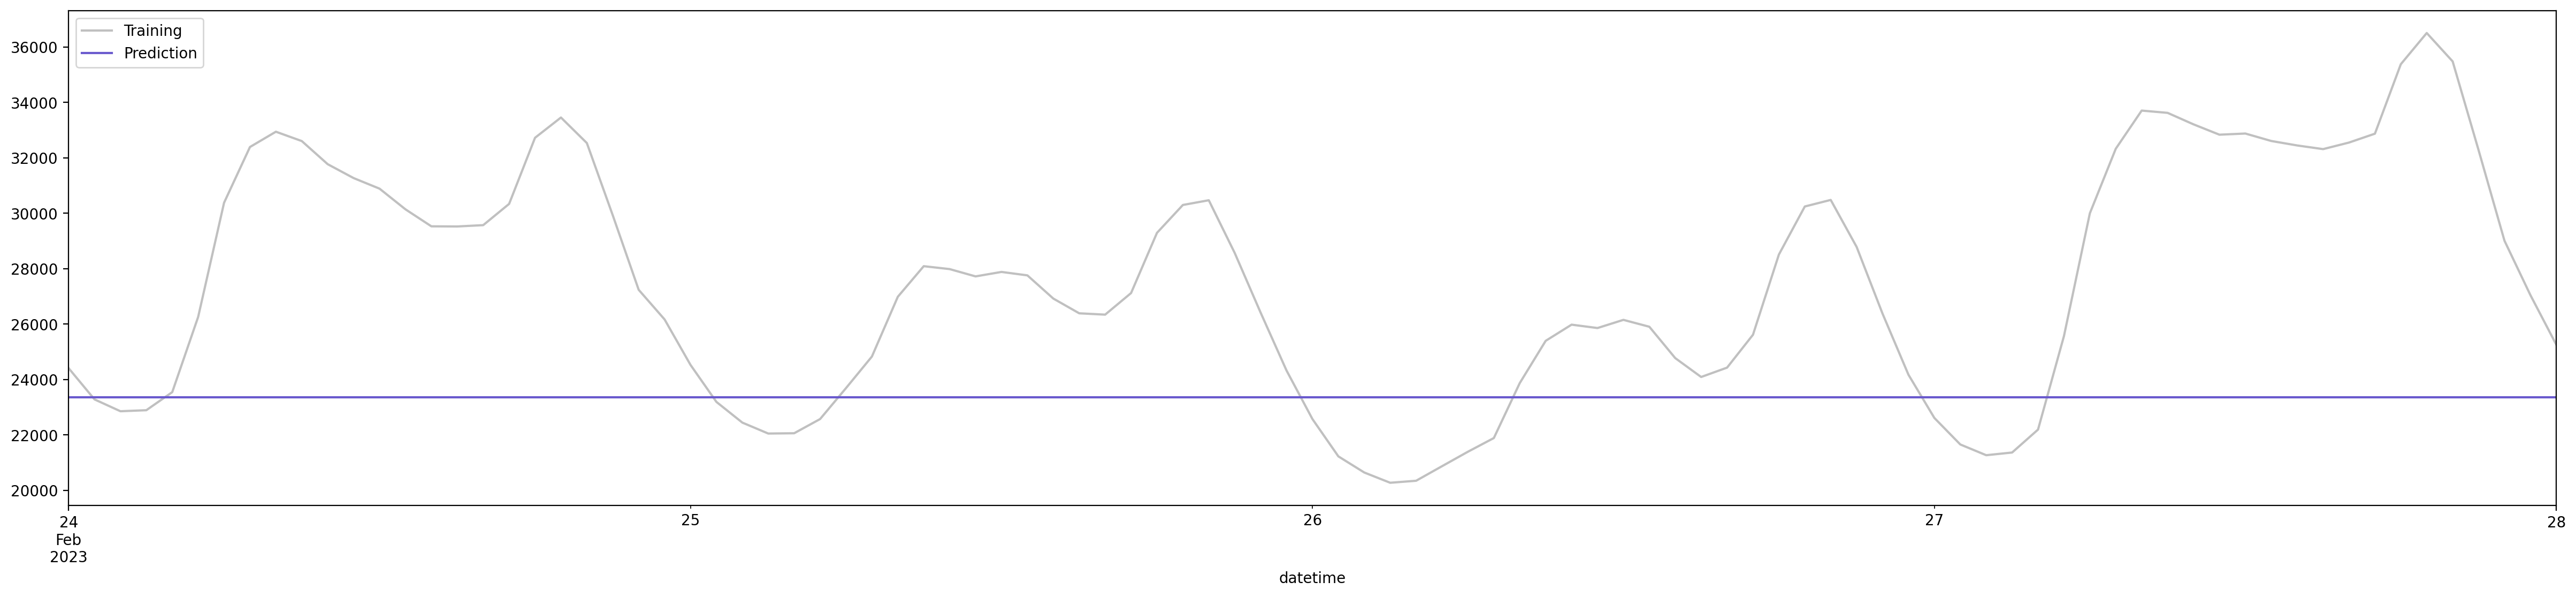

In [234]:
training.plot(figsize=(30,6), color='firebrick', ls='-');
test.plot(figsize=(30,6), color='silver', ls='-');
prediction.plot(figsize=(30,6), color='slateblue', ls='-');
plt.legend(['Training', 'Prediction'])

In [235]:
print('MAE: ', mean_absolute_error(test, prediction))

MAE:  4710.93935857899


The ARIMA model captures the trend of the series

We tested with a SARIMA Model

We add a seasonal component to the series

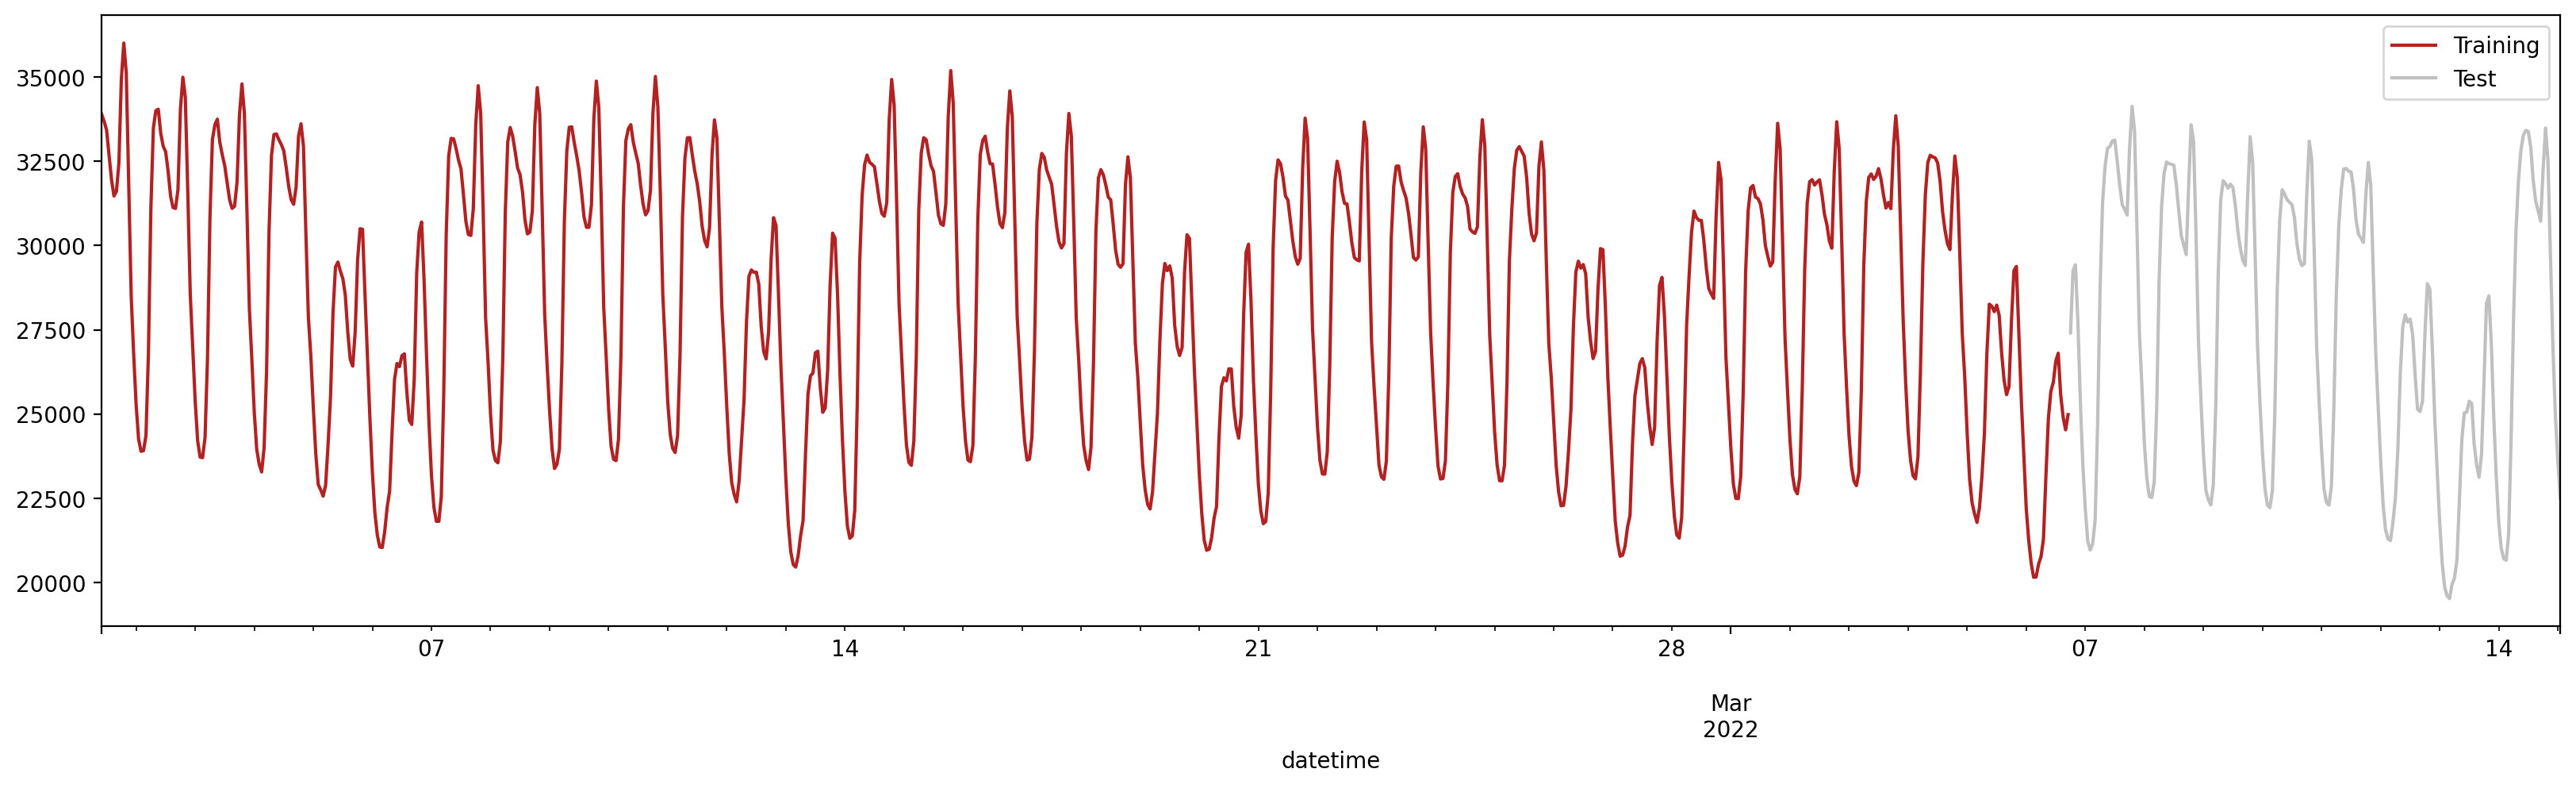

In [236]:
seasonality = np.sin(np.linspace(start=0, stop=100, num=df[:1000].shape[0])) * 5
y = df["RealDemand"].values[:1000] + seasonality
ts = pd.Series(y, index=df[:1000].index)
n = len(ts)
split = 0.2 # % de datos para test
n_training = int((1-split)*n)
training = ts[:n_training]
test = ts[n_training:]
training.plot(figsize=(20,5), color='firebrick', ls='-');
test.plot(figsize=(20,5), color='silver', ls='-');
plt.legend(['Training', 'Test'])

We acquire the size of the station

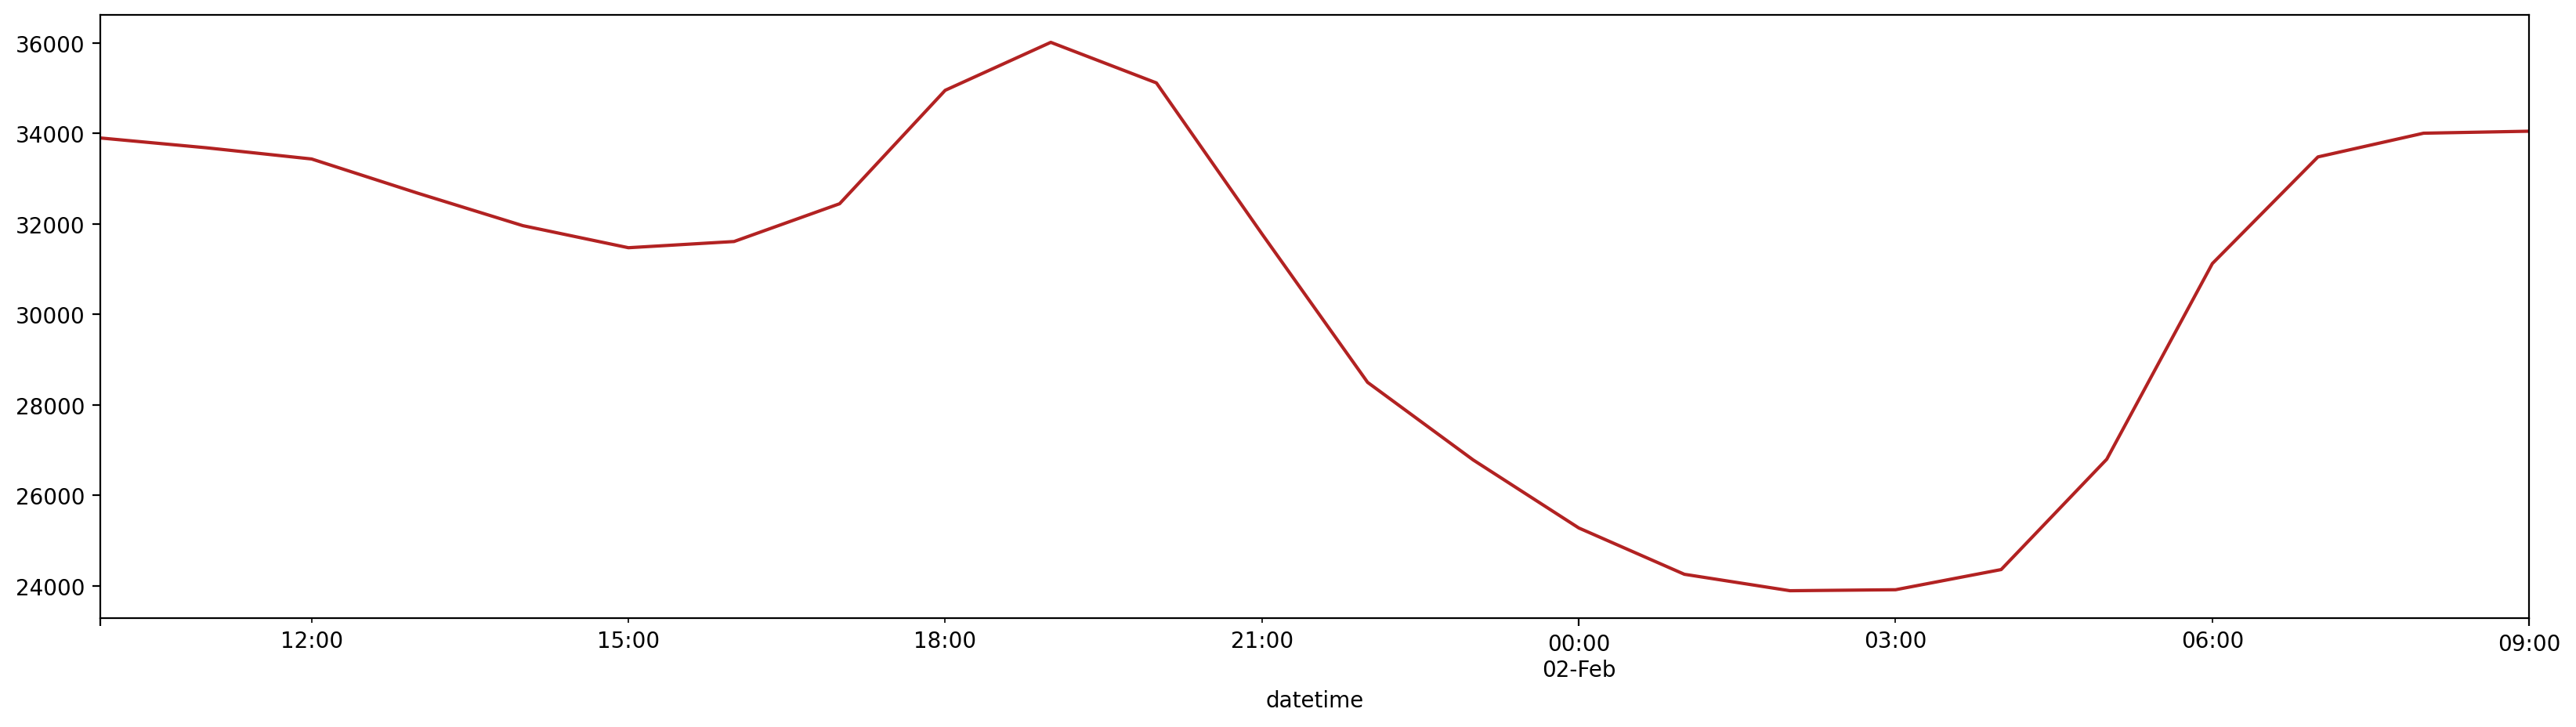

In [237]:
seasonal_lag = 24

training[:seasonal_lag].plot(figsize=(20,5), color='firebrick', ls='-');

Approximately, it seems that the period lasts about 24 hours. We apply the difference.

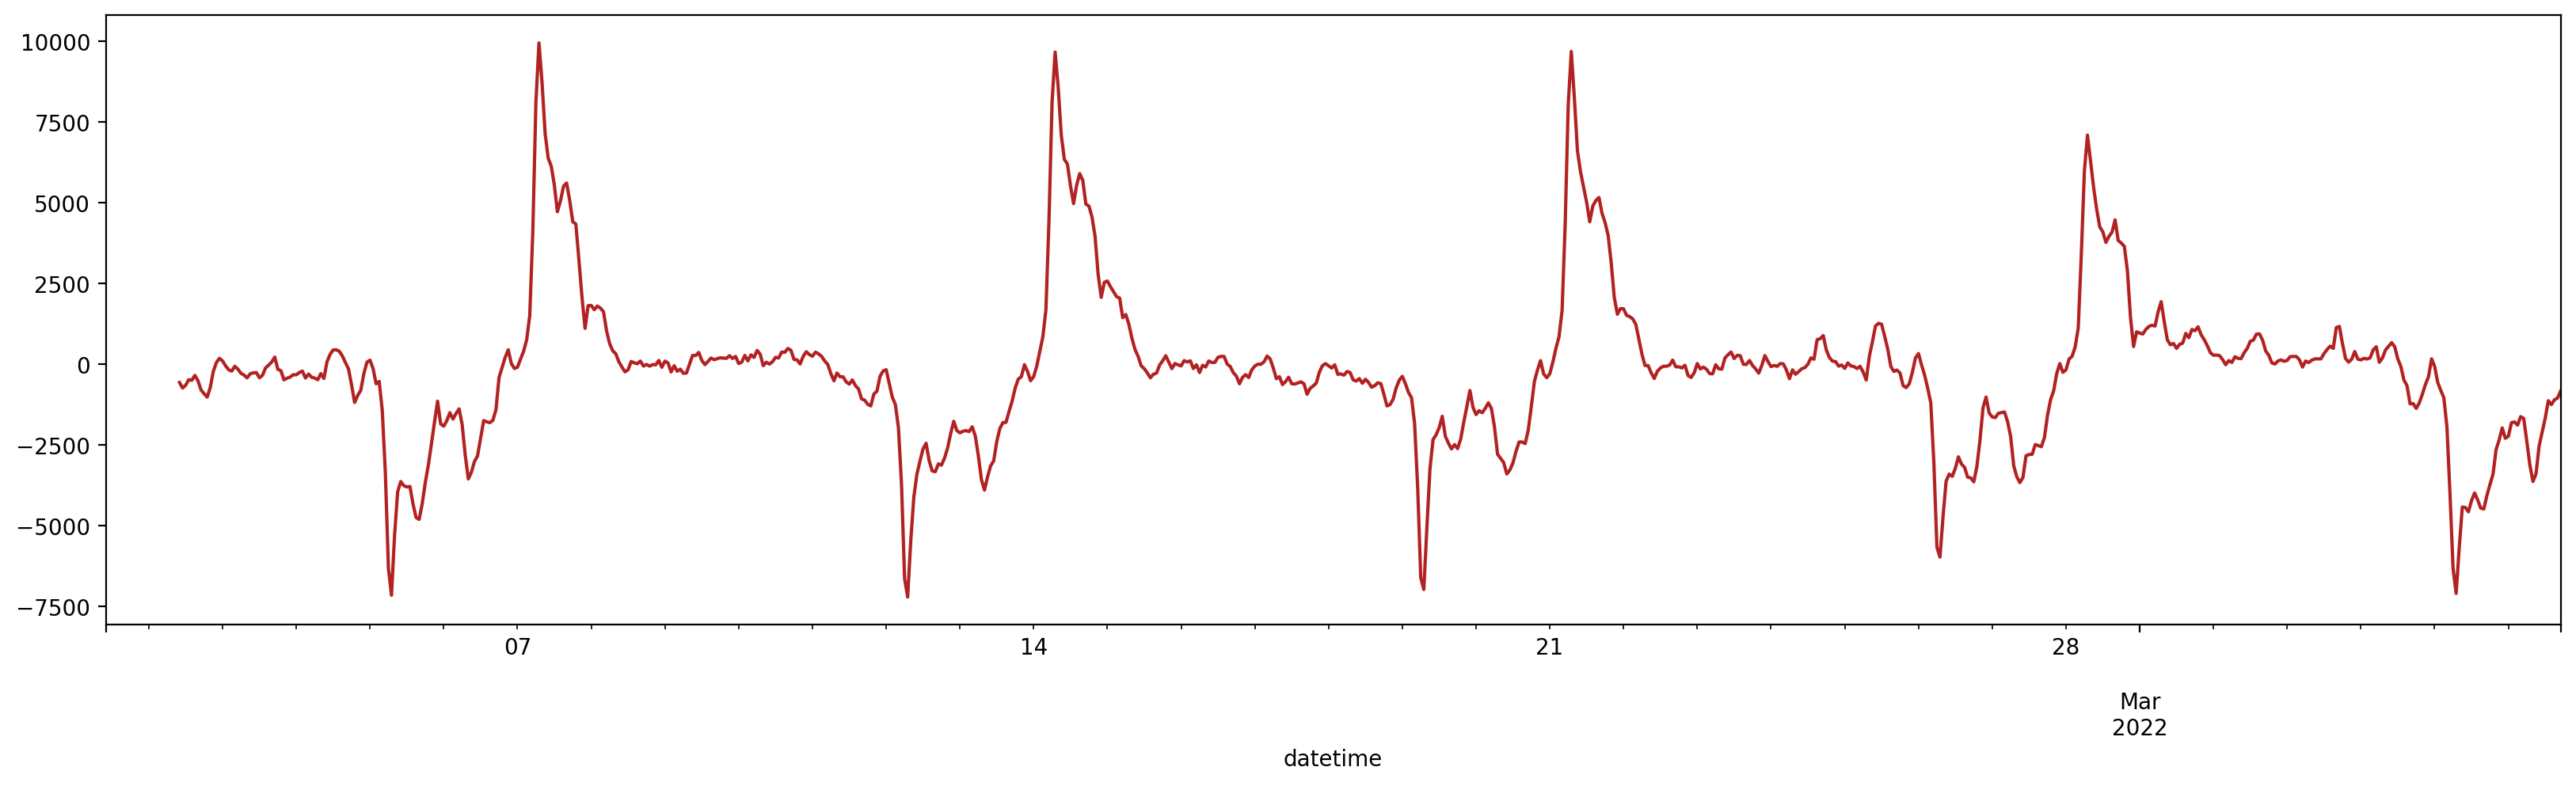

In [238]:
training_1sd = training - training.shift(seasonal_lag)
training_1sd.plot(figsize=(20,5), color='firebrick');

It seems like a series that can be stationary, we check it:

In [239]:
adfuller(training_1sd.fillna(method='bfill'))[1]

2.8786817756337752e-05

We see the autocorrelation graphs

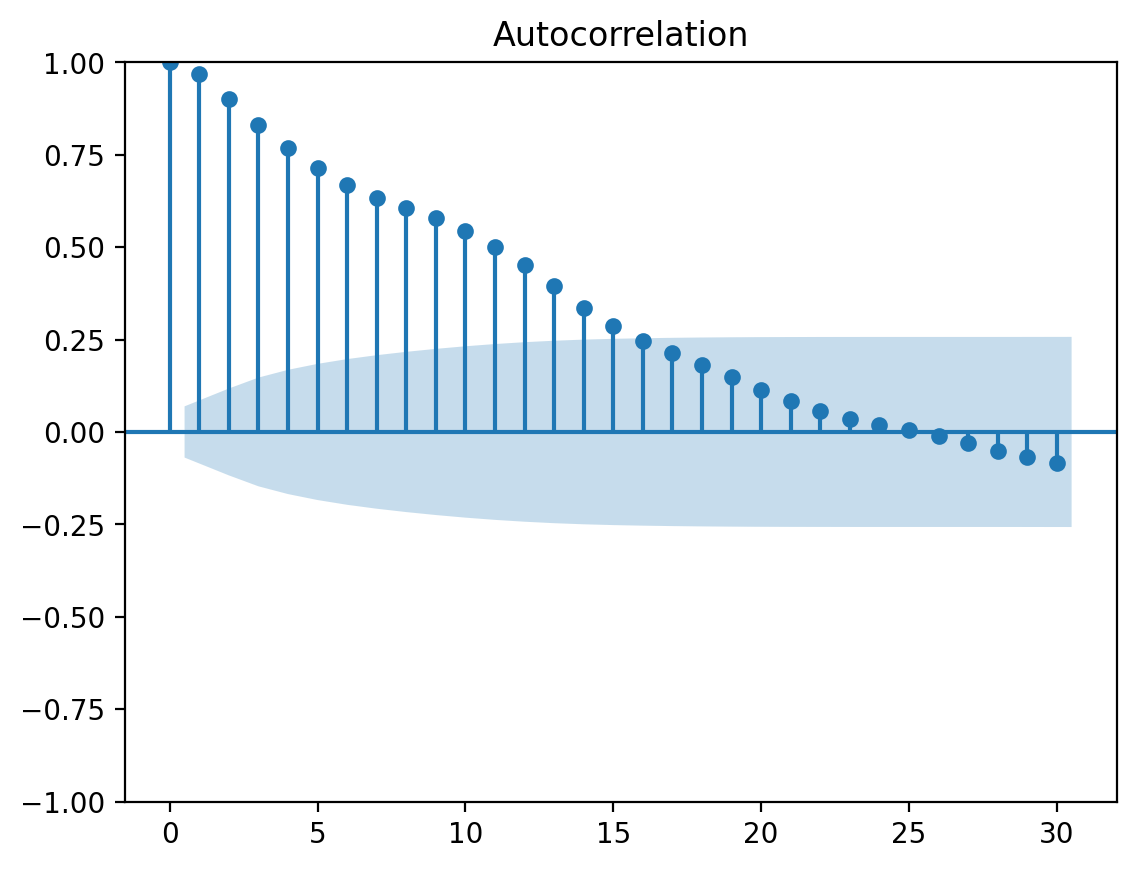

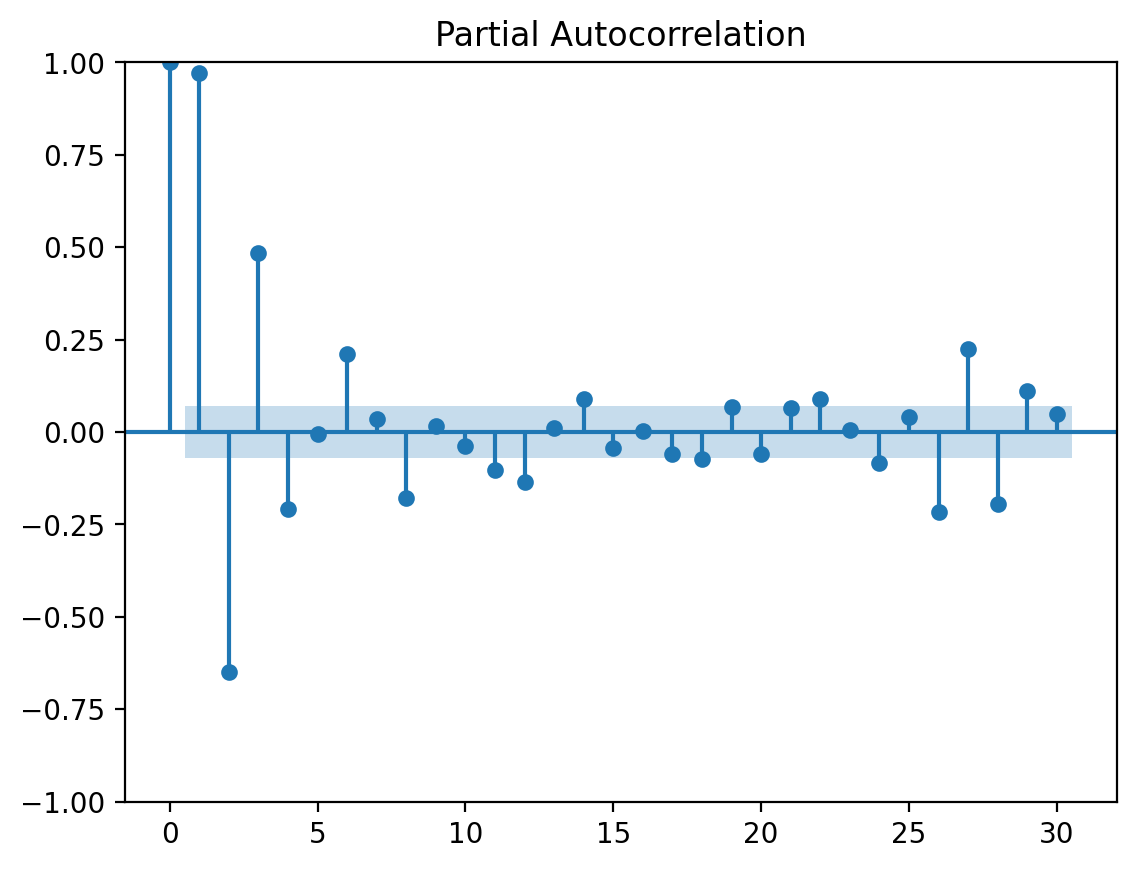

In [240]:
plot_acf(training_1sd.fillna(method='bfill'), lags=30);
plot_pacf(training_1sd.fillna(method='bfill'), lags=30);

The partial autocorrelation graph decreases more abruptly from K=3, so q = 3 and therefore params = (0,0,3)

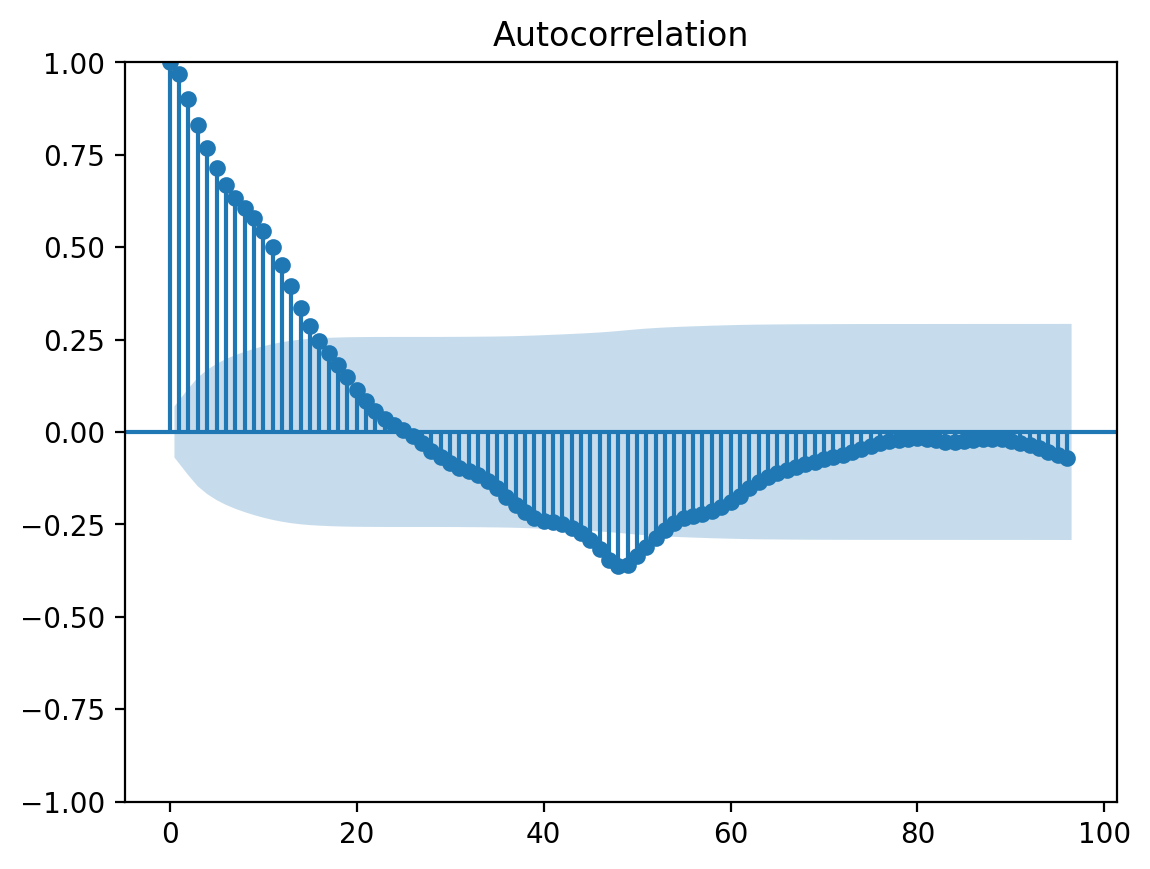

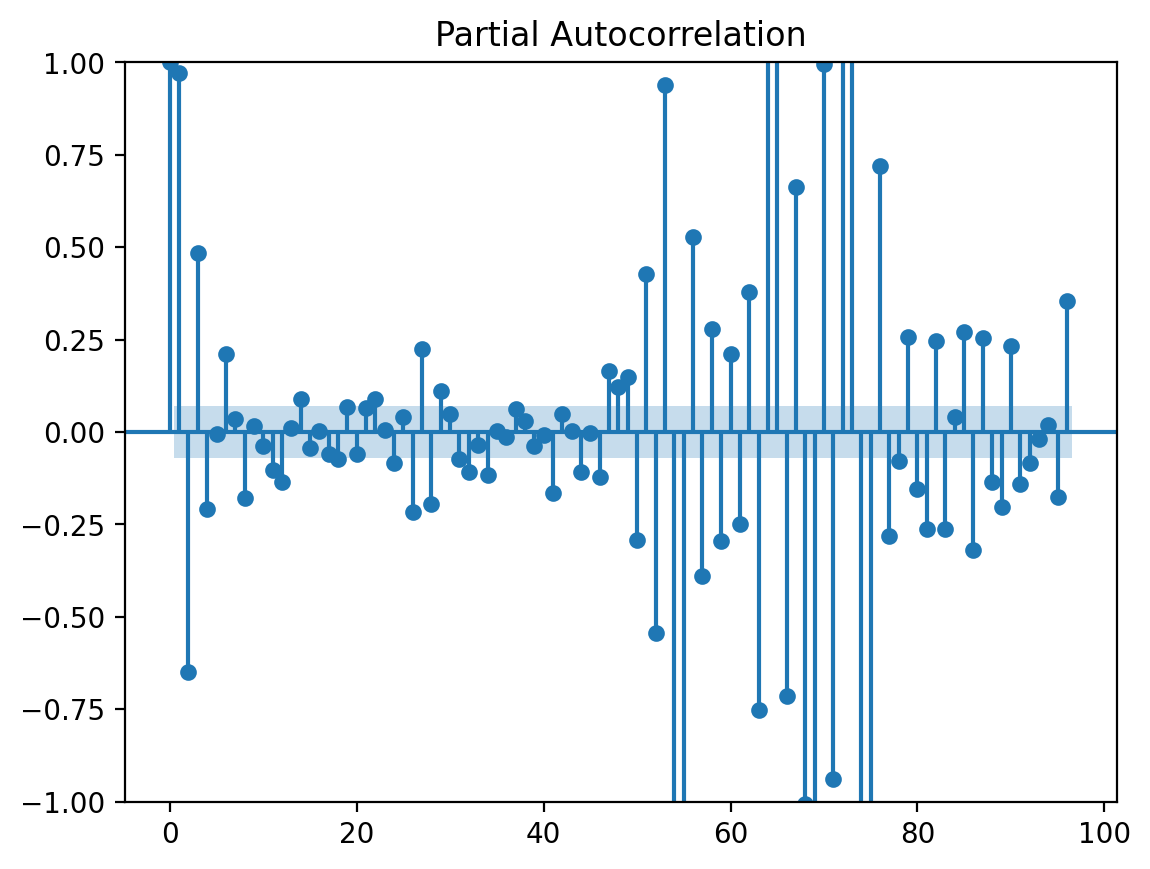

In [241]:
plot_acf(training_1sd.fillna(method='bfill'), lags=seasonal_lag*4);
plot_pacf(training_1sd.fillna(method='bfill'), lags=seasonal_lag*4);

It seems that the partial correlation graph decreases and increases suddenly, so we will use P=3

In [242]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

season = seasonal_lag
params = (0,0,3)
seasonal_params = (3,1,0, seasonal_lag)
m = SARIMAX(training, order=params, seasonal_order=seasonal_params)
result = m.fit()
prediction = pd.Series(result.forecast(len(test)), index=test.index)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23154D+00    |proj g|=  1.62151D+00


 This problem is unconstrained.



At iterate    5    f=  8.37625D+00    |proj g|=  2.12251D-02

At iterate   10    f=  8.37520D+00    |proj g|=  8.79778D-04

At iterate   15    f=  8.37519D+00    |proj g|=  1.22280D-03

At iterate   20    f=  8.37423D+00    |proj g|=  1.60367D-02

At iterate   25    f=  8.34097D+00    |proj g|=  9.80965D-02

At iterate   30    f=  8.08792D+00    |proj g|=  8.38481D-01

At iterate   35    f=  7.98850D+00    |proj g|=  2.12669D-01

At iterate   40    f=  7.98678D+00    |proj g|=  3.71681D-01

At iterate   45    f=  7.98522D+00    |proj g|=  6.34492D-02

At iterate   50    f=  7.98520D+00    |proj g|=  1.42322D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

MAE:  3203.3807628531335


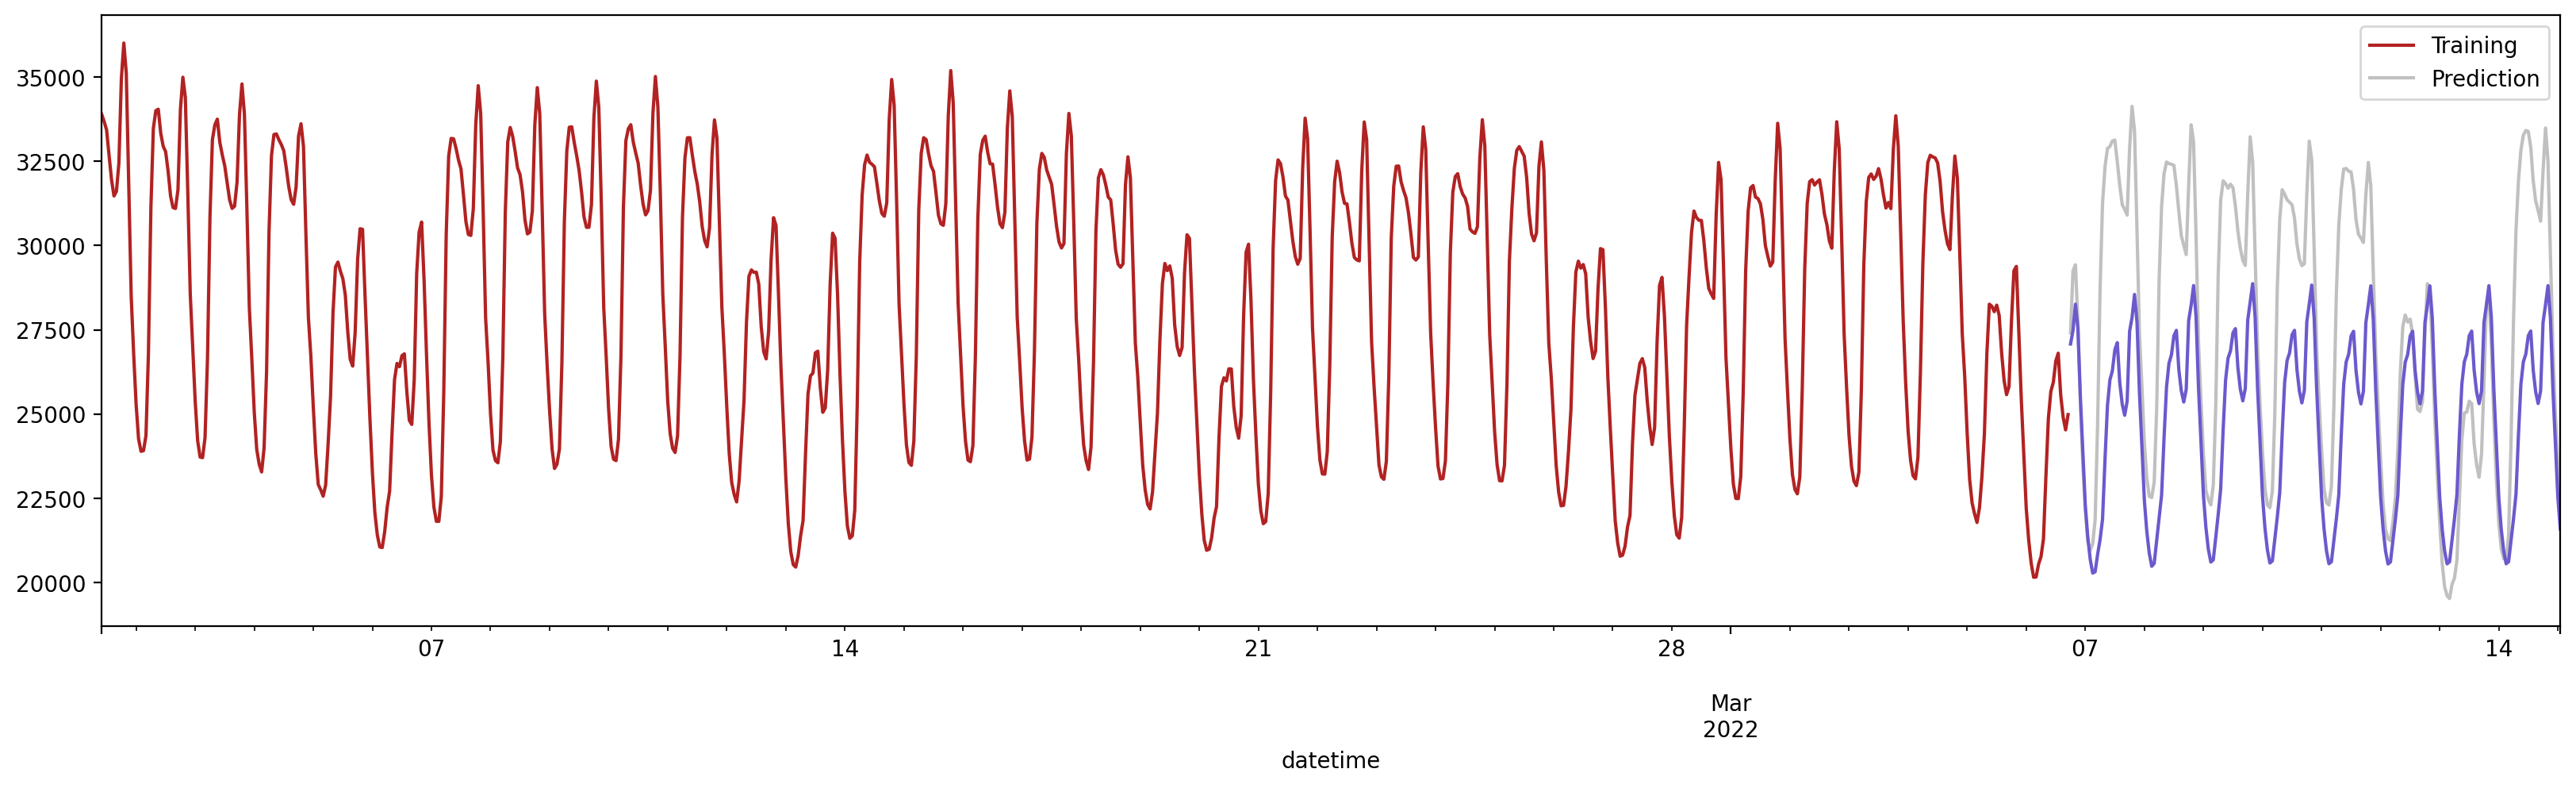

In [243]:
from sklearn.metrics import mean_absolute_error


training.plot(figsize=(20,5), color='firebrick', ls='-');
test.plot(figsize=(20,5), color='silver', ls='-');
prediction.plot(figsize=(20,5), color='slateblue', ls='-');
plt.legend(['Training', 'Prediction'])
print('MAE: ', mean_absolute_error(test, prediction))

In this section I perform a test adding a more defined seasonal component and the order of the series with the objective of checking if with this more defined component the prediction is better.

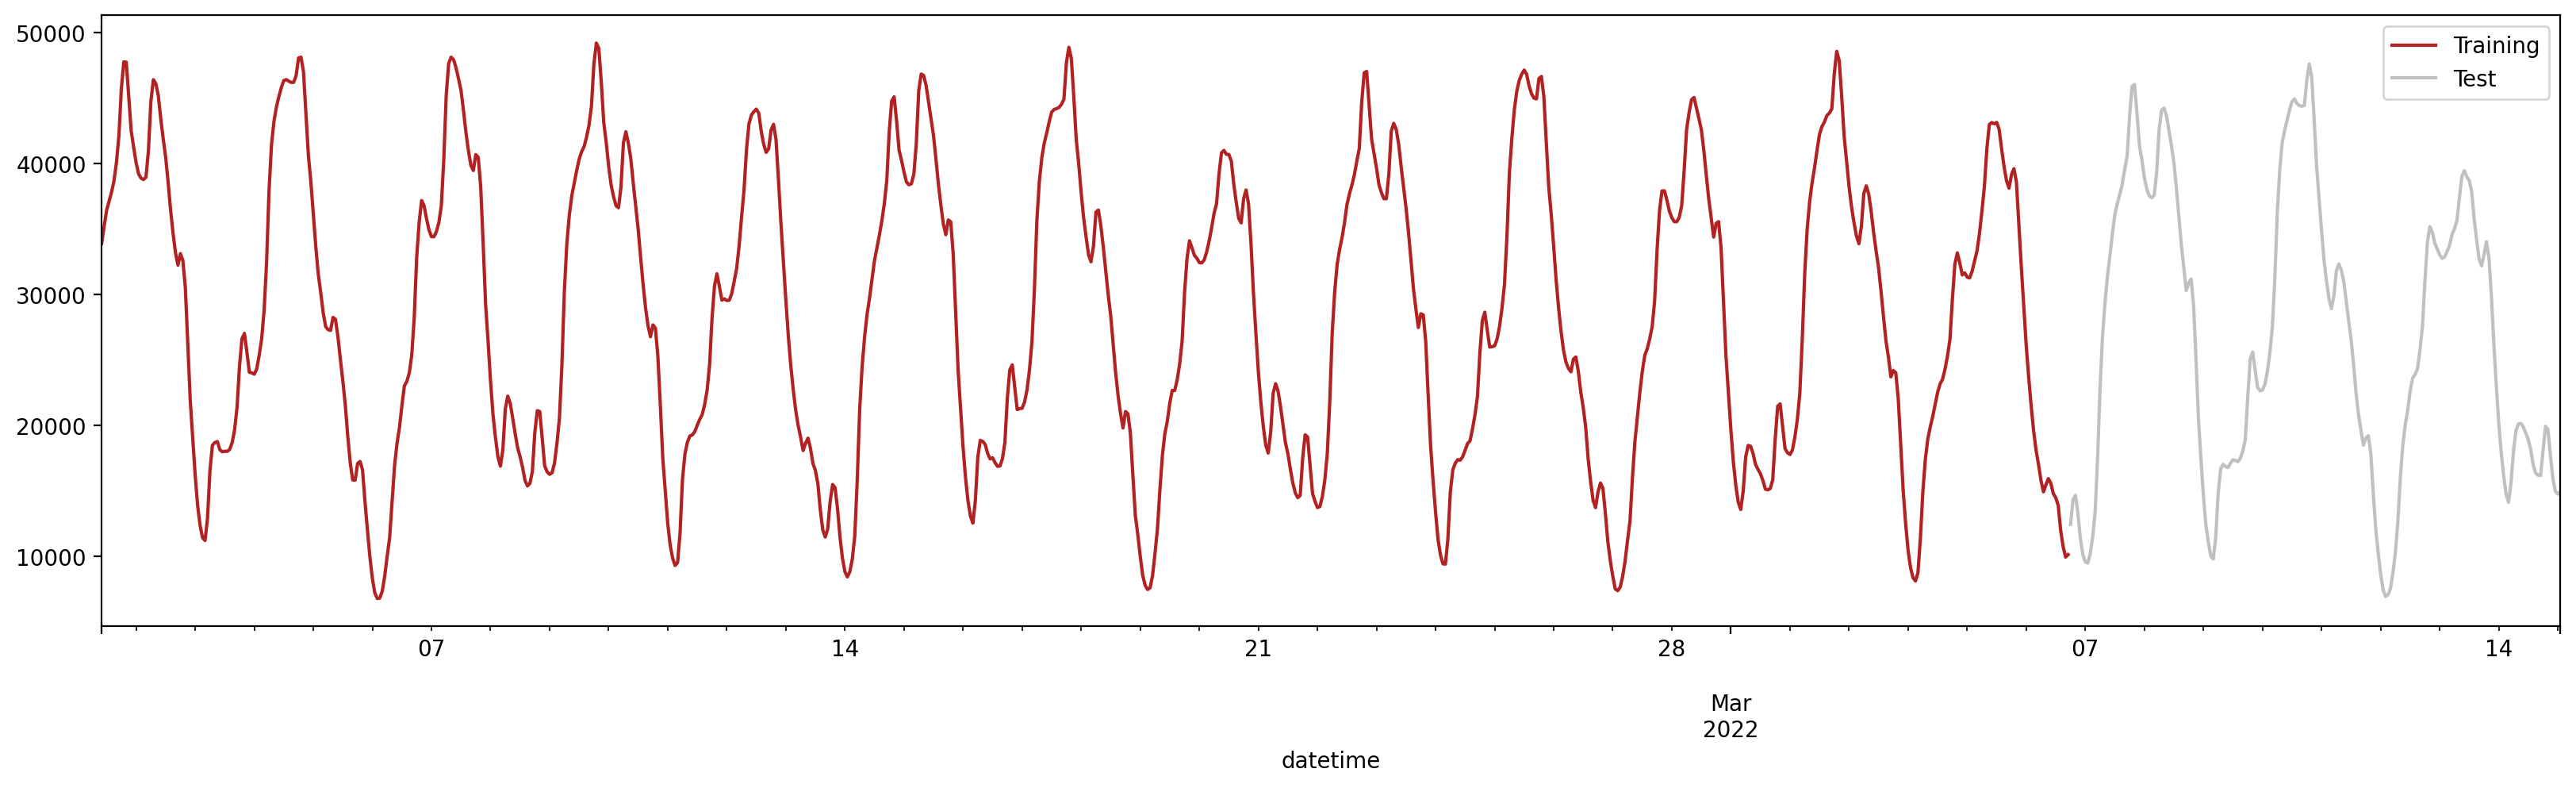

In [164]:
seasonality = np.sin(np.linspace(start=0, stop=100, num=df[:1000].shape[0])) * 15000
y = df["RealDemand"].values[:1000] + seasonality
ts = pd.Series(y, index=df[:1000].index)
n = len(ts)
split = 0.2 # % de datos para test
n_training = int((1-split)*n)
training = ts[:n_training]
test = ts[n_training:]
training.plot(figsize=(20,5), color='firebrick', ls='-');
test.plot(figsize=(20,5), color='silver', ls='-');
plt.legend(['Training', 'Test'])

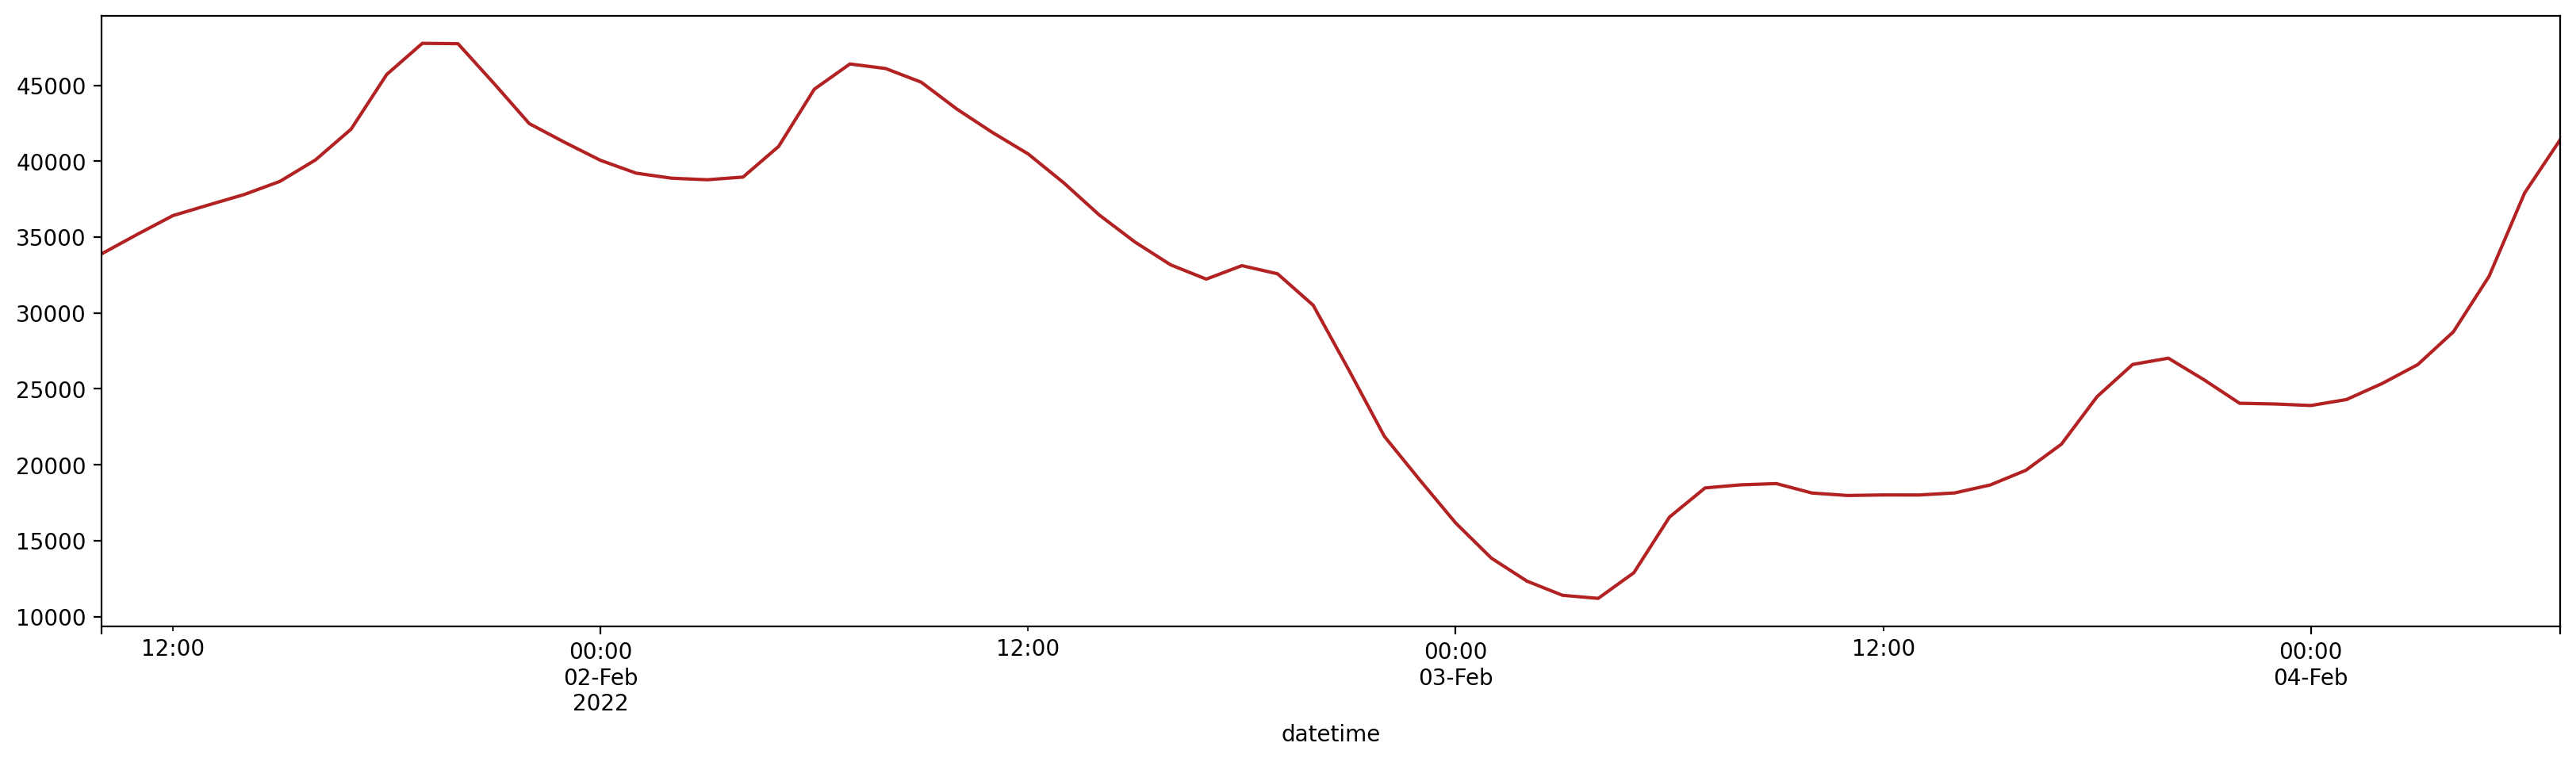

In [171]:
seasonal_lag = 70

training[:seasonal_lag].plot(figsize=(20,5), color='firebrick', ls='-');

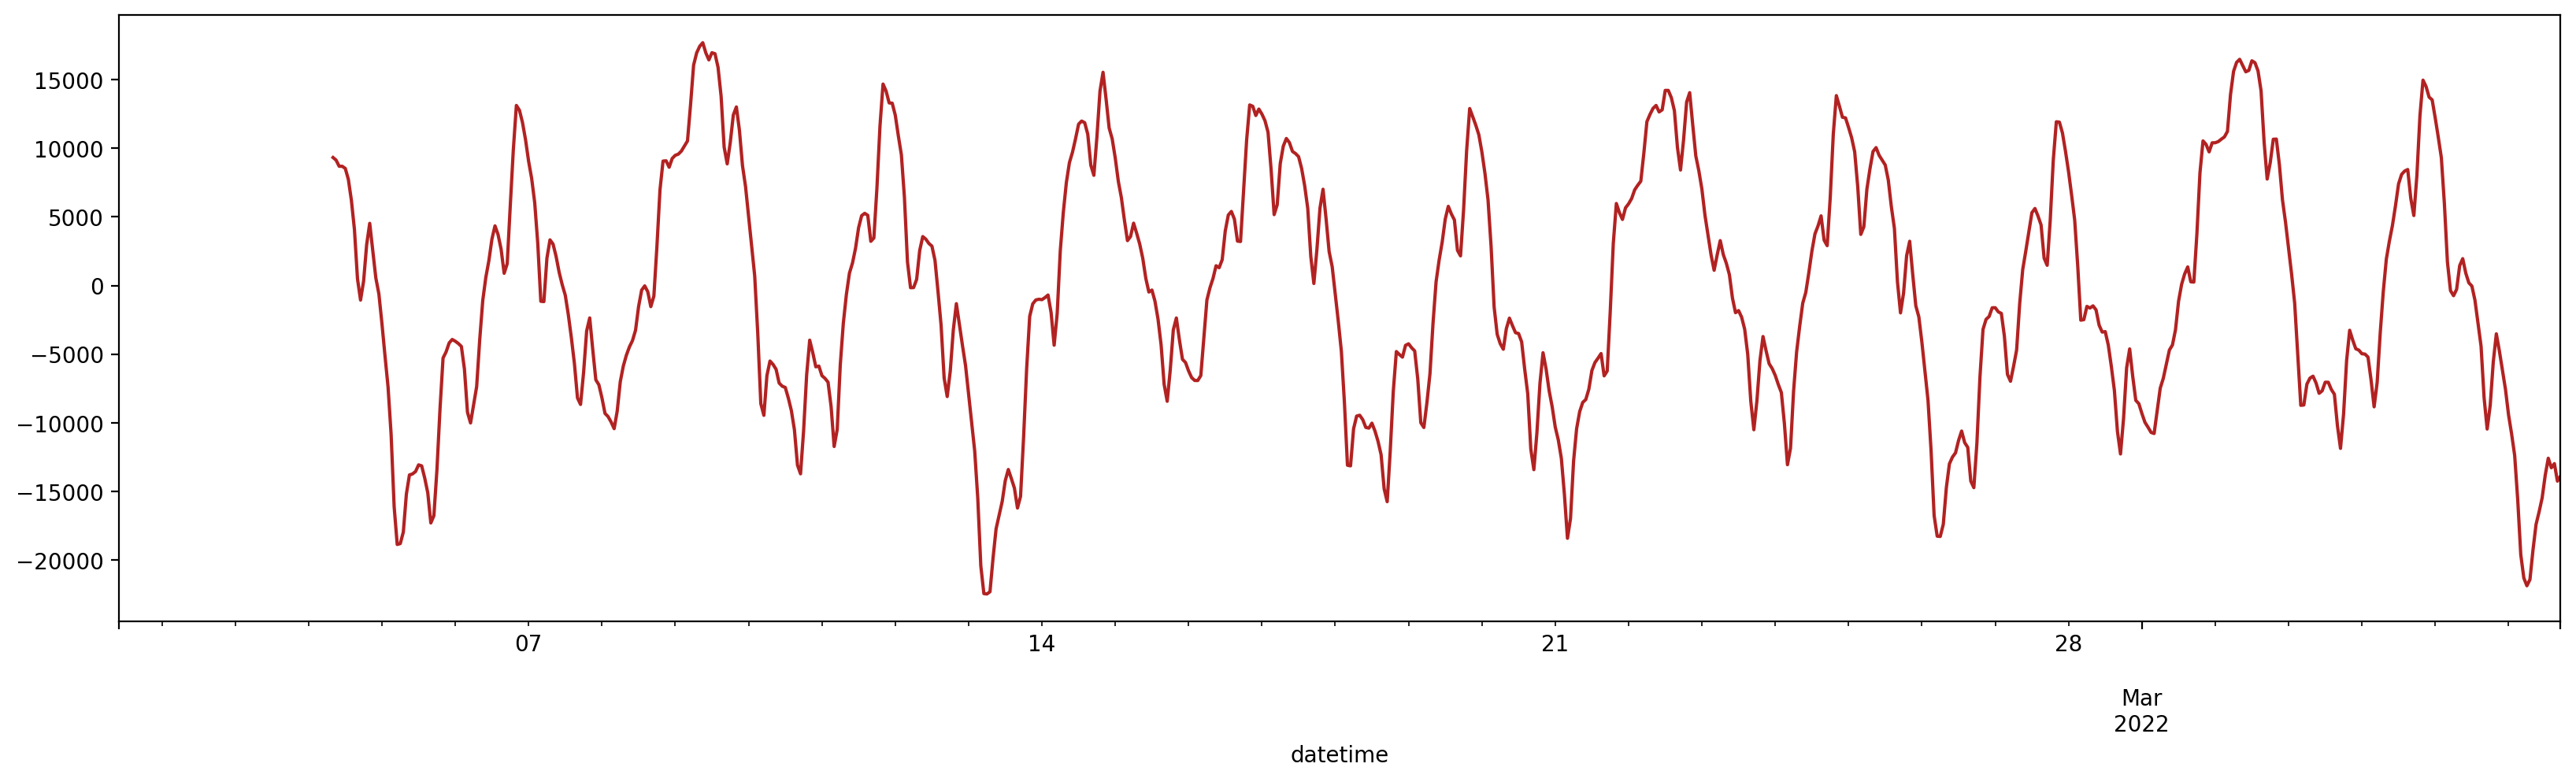

In [172]:
training_1sd = training - training.shift(seasonal_lag)
training_1sd.plot(figsize=(20,5), color='firebrick');

In [173]:
adfuller(training_1sd.fillna(method='bfill'))[1]

3.5792183003069376e-05

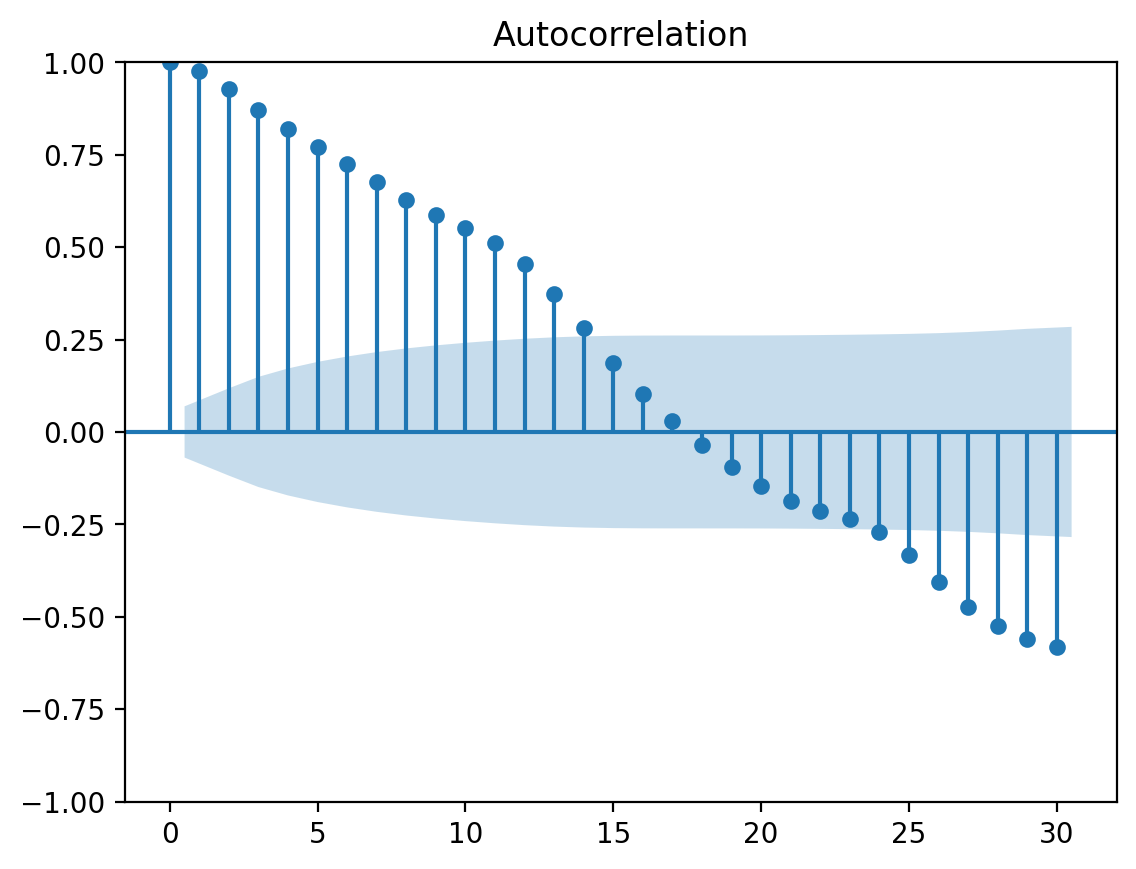

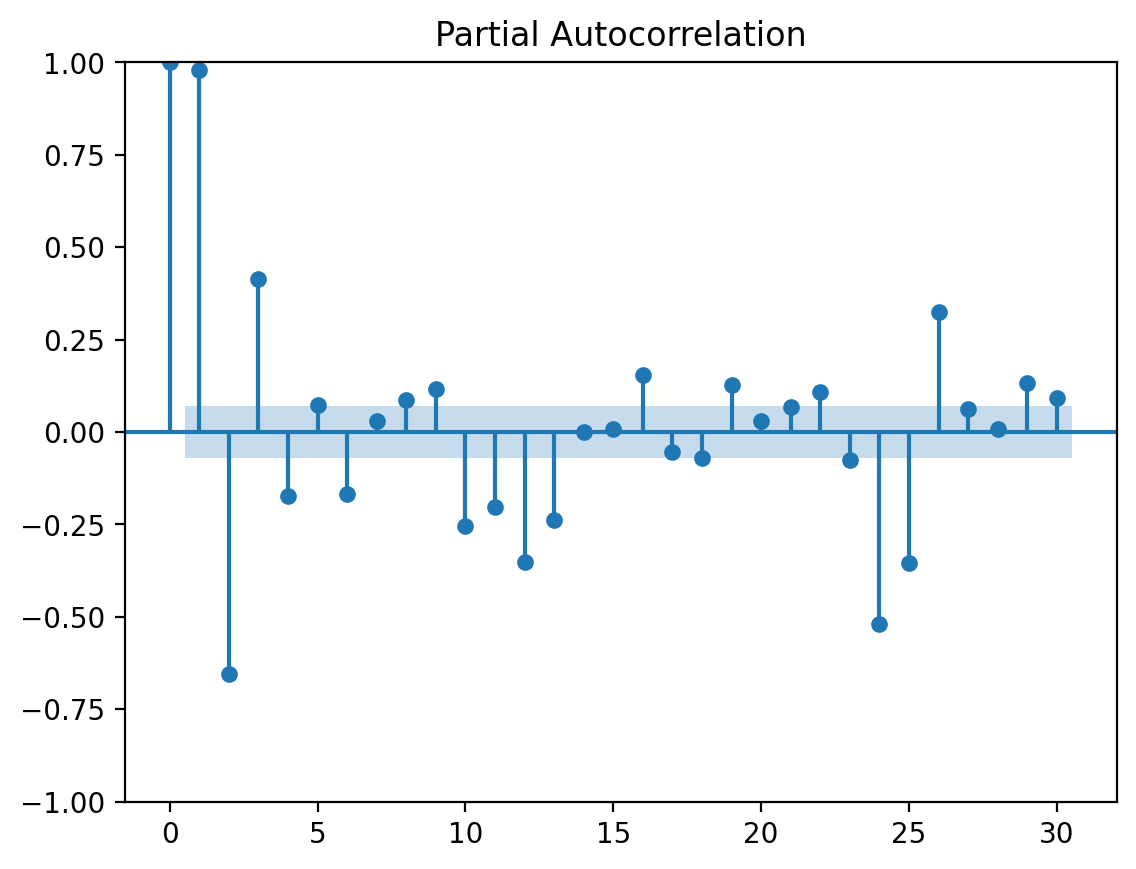

In [174]:
plot_acf(training_1sd.fillna(method='bfill'), lags=30);
plot_pacf(training_1sd.fillna(method='bfill'), lags=30);

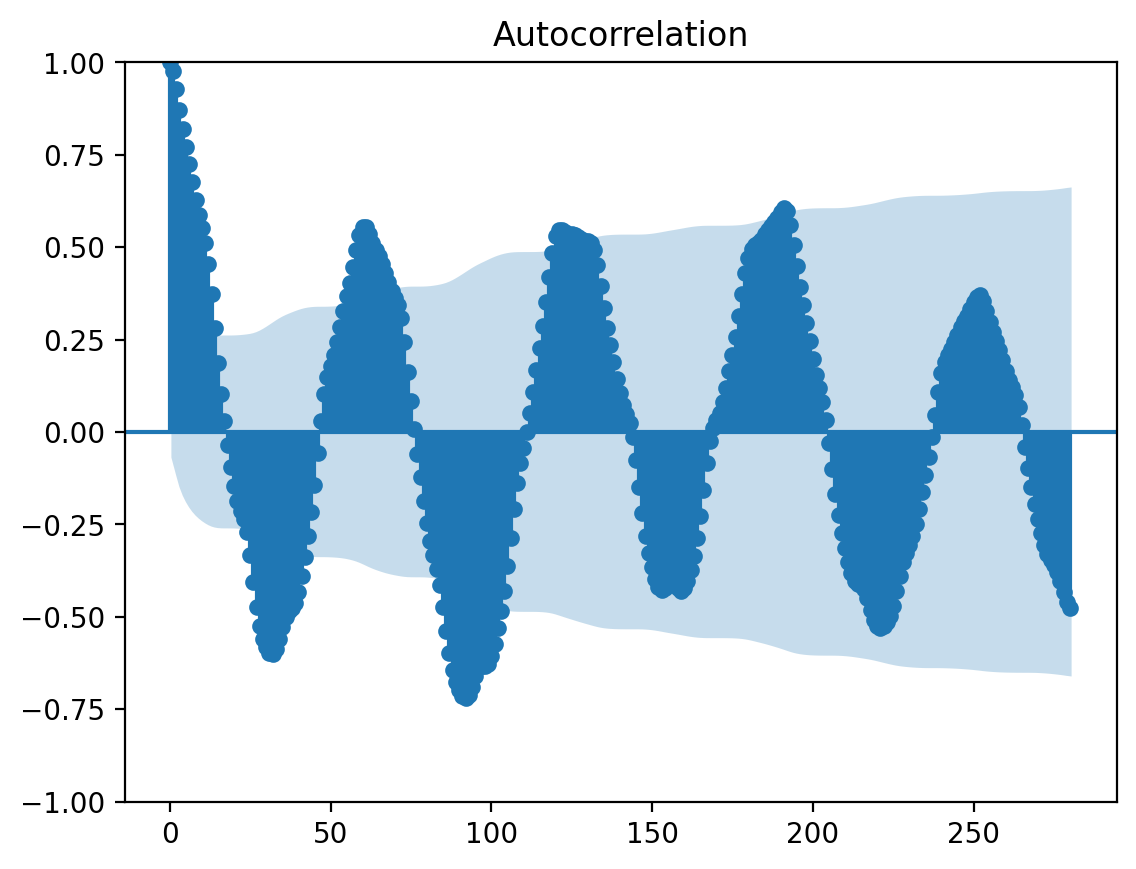

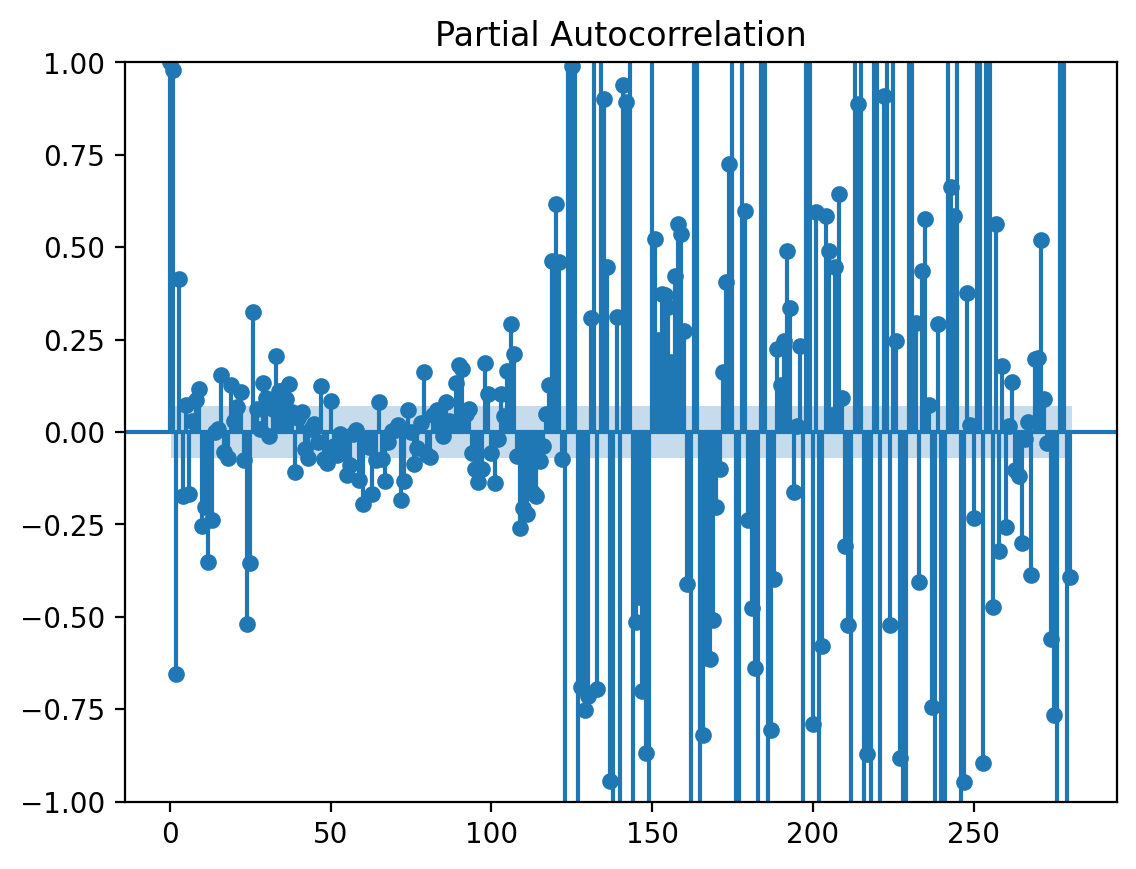

In [175]:
plot_acf(training_1sd.fillna(method='bfill'), lags=seasonal_lag*4);
plot_pacf(training_1sd.fillna(method='bfill'), lags=seasonal_lag*4);

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

season = seasonal_lag
params = (0,0,3)
seasonal_params = (1,1,0, seasonal_lag)
m = SARIMAX(training, order=params, seasonal_order=seasonal_params)
result = m.fit()
prediction = pd.Series(result.forecast(len(test)), index=test.index)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74338D+00    |proj g|=  1.46218D+00


 This problem is unconstrained.



At iterate    5    f=  9.03658D+00    |proj g|=  3.51338D-03

At iterate   10    f=  9.03636D+00    |proj g|=  1.07354D-04

At iterate   15    f=  9.03635D+00    |proj g|=  8.15892D-04

At iterate   20    f=  9.03503D+00    |proj g|=  7.78849D-03

At iterate   25    f=  8.72479D+00    |proj g|=  3.47861D-01

At iterate   30    f=  8.54340D+00    |proj g|=  2.15820D+00

At iterate   35    f=  8.50835D+00    |proj g|=  2.12863D-01

At iterate   40    f=  8.50315D+00    |proj g|=  2.17207D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     59      1     0     0   8.247D-04   8.503D+00
  F =   8.50314958468

MAE:  9981.854515481069


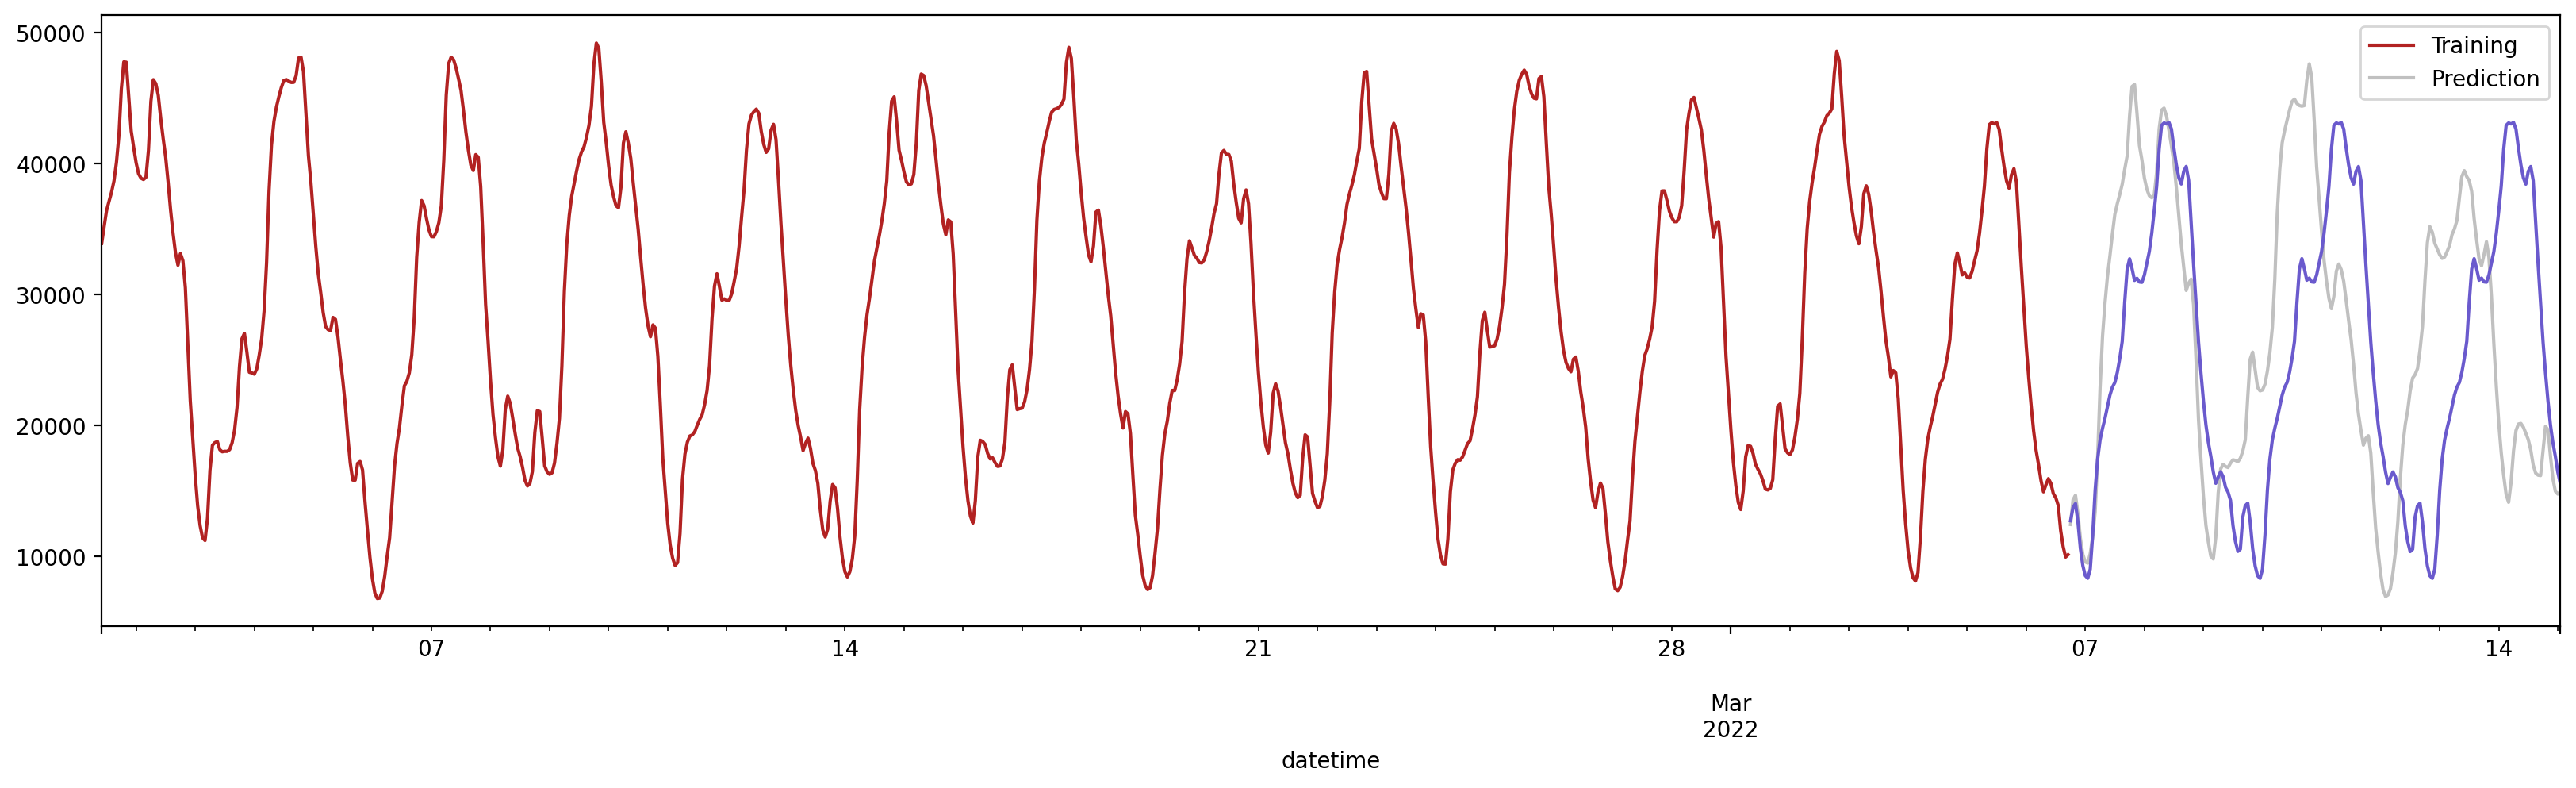

In [177]:
from sklearn.metrics import mean_absolute_error


training.plot(figsize=(20,5), color='firebrick', ls='-');
test.plot(figsize=(20,5), color='silver', ls='-');
prediction.plot(figsize=(20,5), color='slateblue', ls='-');
plt.legend(['Training', 'Prediction'])
print('MAE: ', mean_absolute_error(test, prediction))

We note that the MAE results are for Arima 4710, 3203 for SARIMA with a small seasonal component and 9981 for a SARIMA model with a seasonal component of a high order. We thus verify that, of the three models that we have developed, the one that best predicts the series is SARIMA with a low seasonal component.

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

--- 

With this function we can now evaluate our model. In this case, we must remember that we must evaluate our model on a daily basis, since our objective is to make forecasts one day ahead. To do this, we can use the previous function and go through the values ​​of a test set daily, adding the values ​​to date in the training. We will only use the first days of January to test the method. Let's see how to do it.

In [109]:
test_dates = list(pd.date_range(start=datetime.datetime(2023, 1, 1), end=datetime.datetime(2023, 1, 10), freq='D'))

In [12]:
maes = []
for test_date in test_dates:
    training = df[:test_date-datetime.timedelta(minutes=1)]
    test = df[test_date:test_date+datetime.timedelta(days=1, minutes=-1)]
    result = train_forecast(df, test.index)
    r = mean_absolute_error(test, result)
    maes.append(r)

19:39:49 - cmdstanpy - INFO - Chain [1] start processing
19:39:58 - cmdstanpy - INFO - Chain [1] done processing
19:39:58 - cmdstanpy - INFO - Chain [1] start processing
19:40:06 - cmdstanpy - INFO - Chain [1] done processing
19:40:07 - cmdstanpy - INFO - Chain [1] start processing
19:40:15 - cmdstanpy - INFO - Chain [1] done processing
19:40:16 - cmdstanpy - INFO - Chain [1] start processing
19:40:24 - cmdstanpy - INFO - Chain [1] done processing
19:40:24 - cmdstanpy - INFO - Chain [1] start processing
19:40:32 - cmdstanpy - INFO - Chain [1] done processing
19:40:33 - cmdstanpy - INFO - Chain [1] start processing
19:40:41 - cmdstanpy - INFO - Chain [1] done processing
19:40:42 - cmdstanpy - INFO - Chain [1] start processing
19:40:50 - cmdstanpy - INFO - Chain [1] done processing
19:40:51 - cmdstanpy - INFO - Chain [1] start processing
19:40:59 - cmdstanpy - INFO - Chain [1] done processing
19:40:59 - cmdstanpy - INFO - Chain [1] start processing
19:41:08 - cmdstanpy - INFO - Chain [1]

In [13]:
np.mean(maes)

1678.0329524918009

With this model we can now add the forecast information as a new field in our series in InfluxDB. To do this we will follow the following strategy:
- We will focus only on the latest data available. For the last day, which may not be complete, we will have to add the missing hours.
- We will generate a forecast for each day using the model we created earlier.
- We will upload this forecast directly to InfluxDB

We will implement this process in parts below.


--- 

### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i> Task 3 </font>
<br>

Implements the following function that, given a date, returns a list with the ordered timestamps of its times.

In [14]:
def get_hours(date: datetime.datetime) -> list :
    ######## 
    return list(pd.date_range(start=date, freq='H', periods=24))
    ###

In [15]:
get_hours(datetime.datetime(2023, 2, 28))

[Timestamp('2023-02-28 00:00:00', freq='H'),
 Timestamp('2023-02-28 01:00:00', freq='H'),
 Timestamp('2023-02-28 02:00:00', freq='H'),
 Timestamp('2023-02-28 03:00:00', freq='H'),
 Timestamp('2023-02-28 04:00:00', freq='H'),
 Timestamp('2023-02-28 05:00:00', freq='H'),
 Timestamp('2023-02-28 06:00:00', freq='H'),
 Timestamp('2023-02-28 07:00:00', freq='H'),
 Timestamp('2023-02-28 08:00:00', freq='H'),
 Timestamp('2023-02-28 09:00:00', freq='H'),
 Timestamp('2023-02-28 10:00:00', freq='H'),
 Timestamp('2023-02-28 11:00:00', freq='H'),
 Timestamp('2023-02-28 12:00:00', freq='H'),
 Timestamp('2023-02-28 13:00:00', freq='H'),
 Timestamp('2023-02-28 14:00:00', freq='H'),
 Timestamp('2023-02-28 15:00:00', freq='H'),
 Timestamp('2023-02-28 16:00:00', freq='H'),
 Timestamp('2023-02-28 17:00:00', freq='H'),
 Timestamp('2023-02-28 18:00:00', freq='H'),
 Timestamp('2023-02-28 19:00:00', freq='H'),
 Timestamp('2023-02-28 20:00:00', freq='H'),
 Timestamp('2023-02-28 21:00:00', freq='H'),
 Timestamp

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

--- 

To ingest the forecast into InfluxDB, we can use the following function, similar to the function you used in the first lab and which basically takes the forecast from the Prophet model and ingests it using the InfluxDB Write API. The forecast will be ingested to the same extent as the demand, but with the `CP7Forecast` field.

In [16]:
def save_to_influxdb(df: pd.DataFrame, client: InfluxDBClient, bucket: str, org: str) -> pd.DataFrame:
    """
    Escribe el pronóstico en InfluxDB
    """
    df = df.reset_index()
    df['time'] = df['datetime']
    df['CP7Forecast'] = df['yhat']
    to_write = df[['time', 'CP7Forecast']]
    to_write = to_write.set_index('time')[['CP7Forecast']]
    write_api = client.write_api(write_options=SYNCHRONOUS)
    write_api.write(bucket, org, record=to_write, data_frame_measurement_name='demand')

With these functions we now have everything necessary to be able to write the forecast data to InfluxDB. To do this, starting from an initial day from which we will begin to generate forecasts, we will use a strategy similar to the previous evaluation method, simply taking into account that we will generate the hours instead of using those that appear in a test set. Below we show how to ingest the results from a certain day. You can run the code below to add the forecast to your InfluxDB instance.

In [17]:
begin = datetime.datetime(2023, 2, 22)
dates_to_ingest = pd.date_range(start=begin, end=datetime.datetime.now().date(), freq='D')
dates_to_ingest

DatetimeIndex(['2023-02-22', '2023-02-23', '2023-02-24', '2023-02-25',
               '2023-02-26', '2023-02-27', '2023-02-28', '2023-03-01',
               '2023-03-02', '2023-03-03',
               ...
               '2023-07-21', '2023-07-22', '2023-07-23', '2023-07-24',
               '2023-07-25', '2023-07-26', '2023-07-27', '2023-07-28',
               '2023-07-29', '2023-07-30'],
              dtype='datetime64[ns]', length=159, freq='D')

In [18]:
for dt in dates_to_ingest:
    hours = get_hours(dt)
    print(f"Ingesting for date: {dt}")
    training = df[:dt-datetime.timedelta(minutes=1)]
    result = train_forecast(df, hours)
    save_to_influxdb(result, client, bucket, org)

Ingesting for date: 2023-02-22 00:00:00


19:41:17 - cmdstanpy - INFO - Chain [1] start processing
19:41:25 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-02-23 00:00:00


19:41:26 - cmdstanpy - INFO - Chain [1] start processing
19:41:34 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-02-24 00:00:00


19:41:35 - cmdstanpy - INFO - Chain [1] start processing
19:41:43 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-02-25 00:00:00


19:41:43 - cmdstanpy - INFO - Chain [1] start processing
19:41:51 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-02-26 00:00:00


19:41:52 - cmdstanpy - INFO - Chain [1] start processing
19:42:00 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-02-27 00:00:00


19:42:01 - cmdstanpy - INFO - Chain [1] start processing
19:42:09 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-02-28 00:00:00


19:42:09 - cmdstanpy - INFO - Chain [1] start processing
19:42:18 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-01 00:00:00


19:42:18 - cmdstanpy - INFO - Chain [1] start processing
19:42:26 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-02 00:00:00


19:42:27 - cmdstanpy - INFO - Chain [1] start processing
19:42:35 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-03 00:00:00


19:42:36 - cmdstanpy - INFO - Chain [1] start processing
19:42:44 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-04 00:00:00


19:42:44 - cmdstanpy - INFO - Chain [1] start processing
19:42:52 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-05 00:00:00


19:42:53 - cmdstanpy - INFO - Chain [1] start processing
19:43:01 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-06 00:00:00


19:43:02 - cmdstanpy - INFO - Chain [1] start processing
19:43:10 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-07 00:00:00


19:43:10 - cmdstanpy - INFO - Chain [1] start processing
19:43:18 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-08 00:00:00


19:43:19 - cmdstanpy - INFO - Chain [1] start processing
19:43:27 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-09 00:00:00


19:43:28 - cmdstanpy - INFO - Chain [1] start processing
19:43:36 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-10 00:00:00


19:43:37 - cmdstanpy - INFO - Chain [1] start processing
19:43:45 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-11 00:00:00


19:43:46 - cmdstanpy - INFO - Chain [1] start processing
19:43:54 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-12 00:00:00


19:43:55 - cmdstanpy - INFO - Chain [1] start processing
19:44:03 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-13 00:00:00


19:44:04 - cmdstanpy - INFO - Chain [1] start processing
19:44:12 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-14 00:00:00


19:44:13 - cmdstanpy - INFO - Chain [1] start processing
19:44:21 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-15 00:00:00


19:44:21 - cmdstanpy - INFO - Chain [1] start processing
19:44:30 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-16 00:00:00


19:44:30 - cmdstanpy - INFO - Chain [1] start processing
19:44:38 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-17 00:00:00


19:44:39 - cmdstanpy - INFO - Chain [1] start processing
19:44:47 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-18 00:00:00


19:44:48 - cmdstanpy - INFO - Chain [1] start processing
19:44:56 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-19 00:00:00


19:44:56 - cmdstanpy - INFO - Chain [1] start processing
19:45:05 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-20 00:00:00


19:45:05 - cmdstanpy - INFO - Chain [1] start processing
19:45:13 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-21 00:00:00


19:45:14 - cmdstanpy - INFO - Chain [1] start processing
19:45:22 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-22 00:00:00


19:45:23 - cmdstanpy - INFO - Chain [1] start processing
19:45:31 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-23 00:00:00


19:45:31 - cmdstanpy - INFO - Chain [1] start processing
19:45:40 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-24 00:00:00


19:45:40 - cmdstanpy - INFO - Chain [1] start processing
19:45:48 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-25 00:00:00


19:45:49 - cmdstanpy - INFO - Chain [1] start processing
19:45:57 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-26 00:00:00


19:45:58 - cmdstanpy - INFO - Chain [1] start processing
19:46:06 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-27 00:00:00


19:46:07 - cmdstanpy - INFO - Chain [1] start processing
19:46:15 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-28 00:00:00


19:46:16 - cmdstanpy - INFO - Chain [1] start processing
19:46:24 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-29 00:00:00


19:46:24 - cmdstanpy - INFO - Chain [1] start processing
19:46:32 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-30 00:00:00


19:46:33 - cmdstanpy - INFO - Chain [1] start processing
19:46:41 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-03-31 00:00:00


19:46:42 - cmdstanpy - INFO - Chain [1] start processing
19:46:50 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-01 00:00:00


19:46:51 - cmdstanpy - INFO - Chain [1] start processing
19:46:59 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-02 00:00:00


19:46:59 - cmdstanpy - INFO - Chain [1] start processing
19:47:08 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-03 00:00:00


19:47:08 - cmdstanpy - INFO - Chain [1] start processing
19:47:16 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-04 00:00:00


19:47:17 - cmdstanpy - INFO - Chain [1] start processing
19:47:25 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-05 00:00:00


19:47:26 - cmdstanpy - INFO - Chain [1] start processing
19:47:34 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-06 00:00:00


19:47:34 - cmdstanpy - INFO - Chain [1] start processing
19:47:43 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-07 00:00:00


19:47:43 - cmdstanpy - INFO - Chain [1] start processing
19:47:51 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-08 00:00:00


19:47:52 - cmdstanpy - INFO - Chain [1] start processing
19:48:00 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-09 00:00:00


19:48:00 - cmdstanpy - INFO - Chain [1] start processing
19:48:09 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-10 00:00:00


19:48:09 - cmdstanpy - INFO - Chain [1] start processing
19:48:17 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-11 00:00:00


19:48:18 - cmdstanpy - INFO - Chain [1] start processing
19:48:26 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-12 00:00:00


19:48:27 - cmdstanpy - INFO - Chain [1] start processing
19:48:35 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-13 00:00:00


19:48:35 - cmdstanpy - INFO - Chain [1] start processing
19:48:44 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-14 00:00:00


19:48:44 - cmdstanpy - INFO - Chain [1] start processing
19:48:52 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-15 00:00:00


19:48:53 - cmdstanpy - INFO - Chain [1] start processing
19:49:01 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-16 00:00:00


19:49:02 - cmdstanpy - INFO - Chain [1] start processing
19:49:10 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-17 00:00:00


19:49:11 - cmdstanpy - INFO - Chain [1] start processing
19:49:19 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-18 00:00:00


19:49:19 - cmdstanpy - INFO - Chain [1] start processing
19:49:28 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-19 00:00:00


19:49:28 - cmdstanpy - INFO - Chain [1] start processing
19:49:37 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-20 00:00:00


19:49:37 - cmdstanpy - INFO - Chain [1] start processing
19:49:45 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-21 00:00:00


19:49:46 - cmdstanpy - INFO - Chain [1] start processing
19:49:54 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-22 00:00:00


19:49:55 - cmdstanpy - INFO - Chain [1] start processing
19:50:03 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-23 00:00:00


19:50:03 - cmdstanpy - INFO - Chain [1] start processing
19:50:12 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-24 00:00:00


19:50:12 - cmdstanpy - INFO - Chain [1] start processing
19:50:20 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-25 00:00:00


19:50:21 - cmdstanpy - INFO - Chain [1] start processing
19:50:29 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-26 00:00:00


19:50:30 - cmdstanpy - INFO - Chain [1] start processing
19:50:38 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-27 00:00:00


19:50:39 - cmdstanpy - INFO - Chain [1] start processing
19:50:47 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-28 00:00:00


19:50:47 - cmdstanpy - INFO - Chain [1] start processing
19:50:55 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-29 00:00:00


19:50:56 - cmdstanpy - INFO - Chain [1] start processing
19:51:04 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-04-30 00:00:00


19:51:05 - cmdstanpy - INFO - Chain [1] start processing
19:51:13 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-01 00:00:00


19:51:14 - cmdstanpy - INFO - Chain [1] start processing
19:51:22 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-02 00:00:00


19:51:22 - cmdstanpy - INFO - Chain [1] start processing
19:51:31 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-03 00:00:00


19:51:31 - cmdstanpy - INFO - Chain [1] start processing
19:51:39 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-04 00:00:00


19:51:40 - cmdstanpy - INFO - Chain [1] start processing
19:51:48 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-05 00:00:00


19:51:49 - cmdstanpy - INFO - Chain [1] start processing
19:51:57 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-06 00:00:00


19:51:57 - cmdstanpy - INFO - Chain [1] start processing
19:52:06 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-07 00:00:00


19:52:06 - cmdstanpy - INFO - Chain [1] start processing
19:52:15 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-08 00:00:00


19:52:15 - cmdstanpy - INFO - Chain [1] start processing
19:52:23 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-09 00:00:00


19:52:24 - cmdstanpy - INFO - Chain [1] start processing
19:52:32 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-10 00:00:00


19:52:33 - cmdstanpy - INFO - Chain [1] start processing
19:52:41 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-11 00:00:00


19:52:41 - cmdstanpy - INFO - Chain [1] start processing
19:52:50 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-12 00:00:00


19:52:50 - cmdstanpy - INFO - Chain [1] start processing
19:52:58 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-13 00:00:00


19:52:59 - cmdstanpy - INFO - Chain [1] start processing
19:53:07 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-14 00:00:00


19:53:08 - cmdstanpy - INFO - Chain [1] start processing
19:53:16 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-15 00:00:00


19:53:17 - cmdstanpy - INFO - Chain [1] start processing
19:53:25 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-16 00:00:00


19:53:26 - cmdstanpy - INFO - Chain [1] start processing
19:53:34 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-17 00:00:00


19:53:34 - cmdstanpy - INFO - Chain [1] start processing
19:53:43 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-18 00:00:00


19:53:43 - cmdstanpy - INFO - Chain [1] start processing
19:53:52 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-19 00:00:00


19:53:52 - cmdstanpy - INFO - Chain [1] start processing
19:54:00 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-20 00:00:00


19:54:01 - cmdstanpy - INFO - Chain [1] start processing
19:54:09 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-21 00:00:00


19:54:10 - cmdstanpy - INFO - Chain [1] start processing
19:54:18 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-22 00:00:00


19:54:18 - cmdstanpy - INFO - Chain [1] start processing
19:54:27 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-23 00:00:00


19:54:27 - cmdstanpy - INFO - Chain [1] start processing
19:54:35 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-24 00:00:00


19:54:36 - cmdstanpy - INFO - Chain [1] start processing
19:54:44 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-25 00:00:00


19:54:45 - cmdstanpy - INFO - Chain [1] start processing
19:54:53 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-26 00:00:00


19:54:54 - cmdstanpy - INFO - Chain [1] start processing
19:55:02 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-27 00:00:00


19:55:02 - cmdstanpy - INFO - Chain [1] start processing
19:55:10 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-28 00:00:00


19:55:11 - cmdstanpy - INFO - Chain [1] start processing
19:55:19 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-29 00:00:00


19:55:20 - cmdstanpy - INFO - Chain [1] start processing
19:55:28 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-30 00:00:00


19:55:29 - cmdstanpy - INFO - Chain [1] start processing
19:55:37 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-05-31 00:00:00


19:55:37 - cmdstanpy - INFO - Chain [1] start processing
19:55:46 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-01 00:00:00


19:55:46 - cmdstanpy - INFO - Chain [1] start processing
19:55:54 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-02 00:00:00


19:55:55 - cmdstanpy - INFO - Chain [1] start processing
19:56:03 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-03 00:00:00


19:56:04 - cmdstanpy - INFO - Chain [1] start processing
19:56:12 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-04 00:00:00


19:56:13 - cmdstanpy - INFO - Chain [1] start processing
19:56:21 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-05 00:00:00


19:56:21 - cmdstanpy - INFO - Chain [1] start processing
19:56:30 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-06 00:00:00


19:56:30 - cmdstanpy - INFO - Chain [1] start processing
19:56:39 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-07 00:00:00


19:56:39 - cmdstanpy - INFO - Chain [1] start processing
19:56:48 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-08 00:00:00


19:56:48 - cmdstanpy - INFO - Chain [1] start processing
19:56:56 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-09 00:00:00


19:56:57 - cmdstanpy - INFO - Chain [1] start processing
19:57:05 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-10 00:00:00


19:57:06 - cmdstanpy - INFO - Chain [1] start processing
19:57:14 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-11 00:00:00


19:57:14 - cmdstanpy - INFO - Chain [1] start processing
19:57:23 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-12 00:00:00


19:57:23 - cmdstanpy - INFO - Chain [1] start processing
19:57:32 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-13 00:00:00


19:57:32 - cmdstanpy - INFO - Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-14 00:00:00


19:57:41 - cmdstanpy - INFO - Chain [1] start processing
19:57:49 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-15 00:00:00


19:57:50 - cmdstanpy - INFO - Chain [1] start processing
19:57:58 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-16 00:00:00


19:57:58 - cmdstanpy - INFO - Chain [1] start processing
19:58:07 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-17 00:00:00


19:58:07 - cmdstanpy - INFO - Chain [1] start processing
19:58:16 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-18 00:00:00


19:58:16 - cmdstanpy - INFO - Chain [1] start processing
19:58:25 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-19 00:00:00


19:58:25 - cmdstanpy - INFO - Chain [1] start processing
19:58:33 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-20 00:00:00


19:58:34 - cmdstanpy - INFO - Chain [1] start processing
19:58:42 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-21 00:00:00


19:58:43 - cmdstanpy - INFO - Chain [1] start processing
19:58:51 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-22 00:00:00


19:58:51 - cmdstanpy - INFO - Chain [1] start processing
19:59:00 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-23 00:00:00


19:59:00 - cmdstanpy - INFO - Chain [1] start processing
19:59:09 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-24 00:00:00


19:59:10 - cmdstanpy - INFO - Chain [1] start processing
19:59:18 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-25 00:00:00


19:59:18 - cmdstanpy - INFO - Chain [1] start processing
19:59:27 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-26 00:00:00


19:59:27 - cmdstanpy - INFO - Chain [1] start processing
19:59:36 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-27 00:00:00


19:59:36 - cmdstanpy - INFO - Chain [1] start processing
19:59:45 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-28 00:00:00


19:59:45 - cmdstanpy - INFO - Chain [1] start processing
19:59:53 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-29 00:00:00


19:59:54 - cmdstanpy - INFO - Chain [1] start processing
20:00:02 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-06-30 00:00:00


20:00:03 - cmdstanpy - INFO - Chain [1] start processing
20:00:11 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-01 00:00:00


20:00:12 - cmdstanpy - INFO - Chain [1] start processing
20:00:20 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-02 00:00:00


20:00:20 - cmdstanpy - INFO - Chain [1] start processing
20:00:29 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-03 00:00:00


20:00:29 - cmdstanpy - INFO - Chain [1] start processing
20:00:38 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-04 00:00:00


20:00:38 - cmdstanpy - INFO - Chain [1] start processing
20:00:46 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-05 00:00:00


20:00:47 - cmdstanpy - INFO - Chain [1] start processing
20:00:55 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-06 00:00:00


20:00:56 - cmdstanpy - INFO - Chain [1] start processing
20:01:04 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-07 00:00:00


20:01:05 - cmdstanpy - INFO - Chain [1] start processing
20:01:13 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-08 00:00:00


20:01:14 - cmdstanpy - INFO - Chain [1] start processing
20:01:22 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-09 00:00:00


20:01:22 - cmdstanpy - INFO - Chain [1] start processing
20:01:31 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-10 00:00:00


20:01:31 - cmdstanpy - INFO - Chain [1] start processing
20:01:39 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-11 00:00:00


20:01:40 - cmdstanpy - INFO - Chain [1] start processing
20:01:48 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-12 00:00:00


20:01:49 - cmdstanpy - INFO - Chain [1] start processing
20:01:57 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-13 00:00:00


20:01:58 - cmdstanpy - INFO - Chain [1] start processing
20:02:06 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-14 00:00:00


20:02:06 - cmdstanpy - INFO - Chain [1] start processing
20:02:15 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-15 00:00:00


20:02:15 - cmdstanpy - INFO - Chain [1] start processing
20:02:23 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-16 00:00:00


20:02:24 - cmdstanpy - INFO - Chain [1] start processing
20:02:32 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-17 00:00:00


20:02:33 - cmdstanpy - INFO - Chain [1] start processing
20:02:41 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-18 00:00:00


20:02:41 - cmdstanpy - INFO - Chain [1] start processing
20:02:50 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-19 00:00:00


20:02:50 - cmdstanpy - INFO - Chain [1] start processing
20:02:59 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-20 00:00:00


20:02:59 - cmdstanpy - INFO - Chain [1] start processing
20:03:07 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-21 00:00:00


20:03:08 - cmdstanpy - INFO - Chain [1] start processing
20:03:16 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-22 00:00:00


20:03:17 - cmdstanpy - INFO - Chain [1] start processing
20:03:25 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-23 00:00:00


20:03:26 - cmdstanpy - INFO - Chain [1] start processing
20:03:34 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-24 00:00:00


20:03:34 - cmdstanpy - INFO - Chain [1] start processing
20:03:43 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-25 00:00:00


20:03:43 - cmdstanpy - INFO - Chain [1] start processing
20:03:51 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-26 00:00:00


20:03:52 - cmdstanpy - INFO - Chain [1] start processing
20:04:00 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-27 00:00:00


20:04:01 - cmdstanpy - INFO - Chain [1] start processing
20:04:09 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-28 00:00:00


20:04:10 - cmdstanpy - INFO - Chain [1] start processing
20:04:18 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-29 00:00:00


20:04:18 - cmdstanpy - INFO - Chain [1] start processing
20:04:27 - cmdstanpy - INFO - Chain [1] done processing


Ingesting for date: 2023-07-30 00:00:00


20:04:27 - cmdstanpy - INFO - Chain [1] start processing
20:04:35 - cmdstanpy - INFO - Chain [1] done processing


When the previous process is finished you should already have the results in InfluxDB. All that remains is to adapt the previous dashboard to also display the forecast data.


--- 

### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i> Task 4</font>
<br>

Add to the graph cell of the dashboard that you created in the first part of the capstone the series predicted by the model that we have trained.

To view the future forecast, you will need to modify the time filter to include the current day.

**Add a screenshot of your dashboard below (including the dashboard with the delivery)**.

Dashboard obtained:
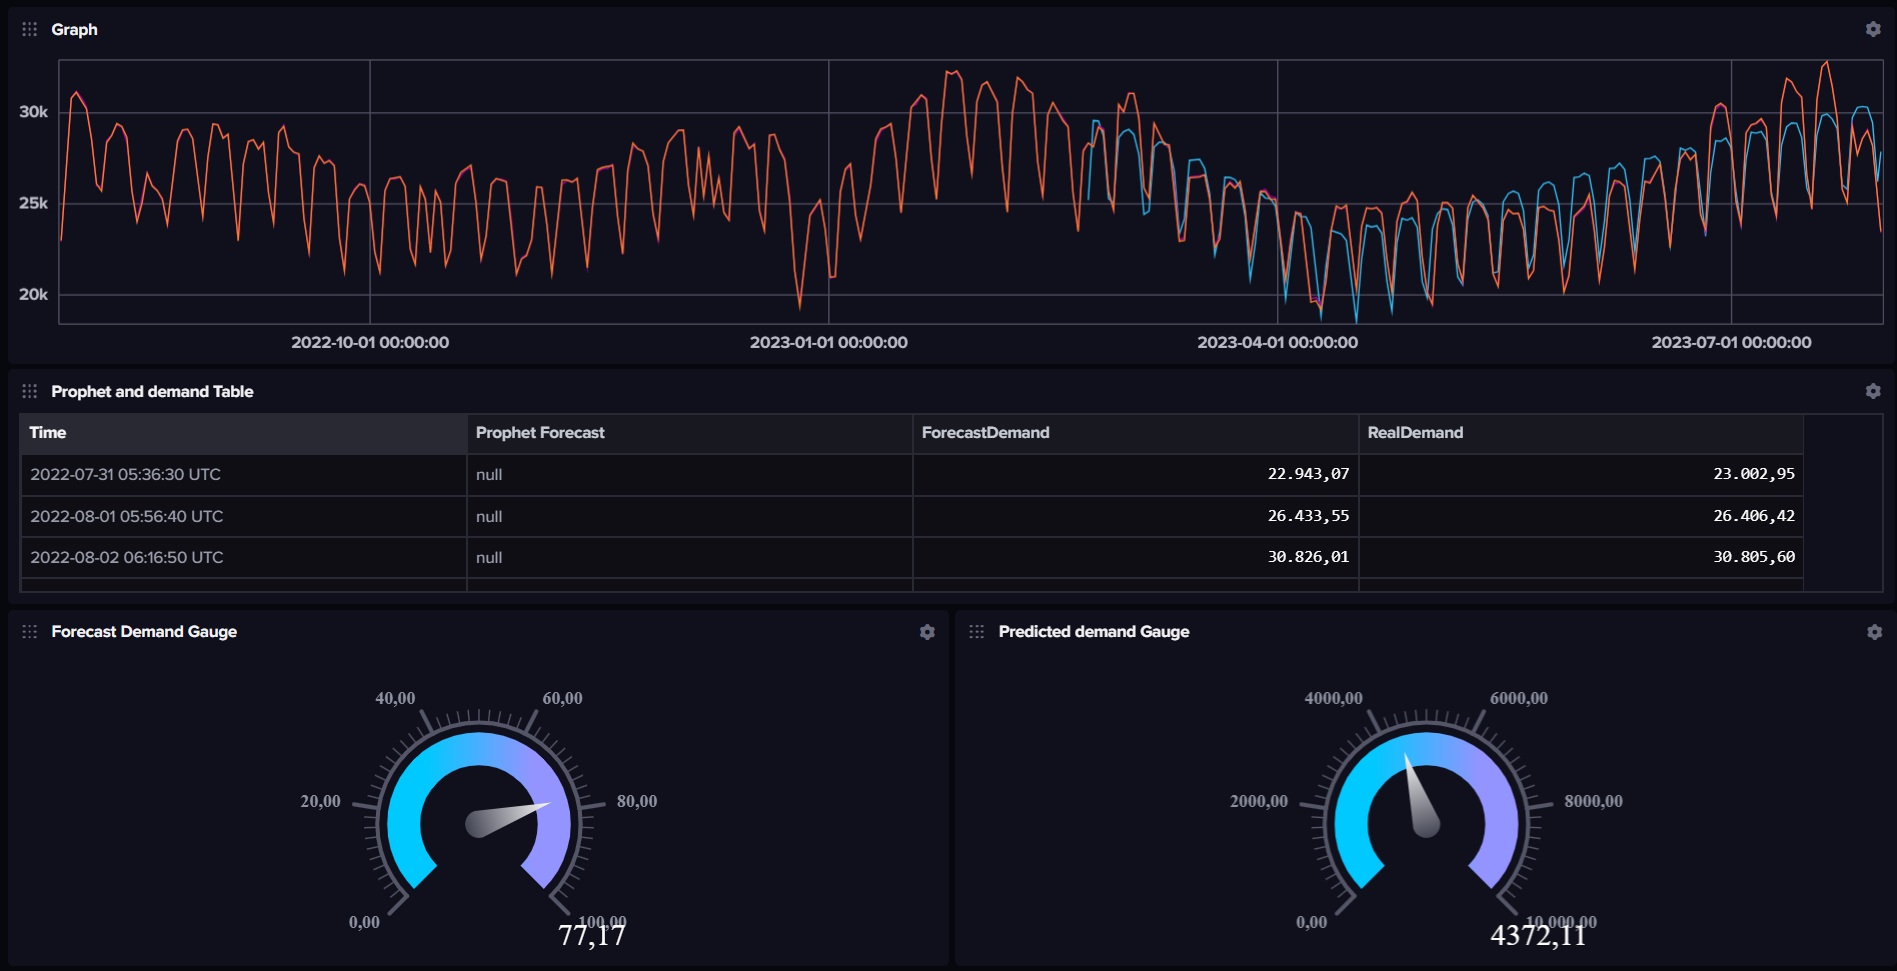
Code used to generate the table:
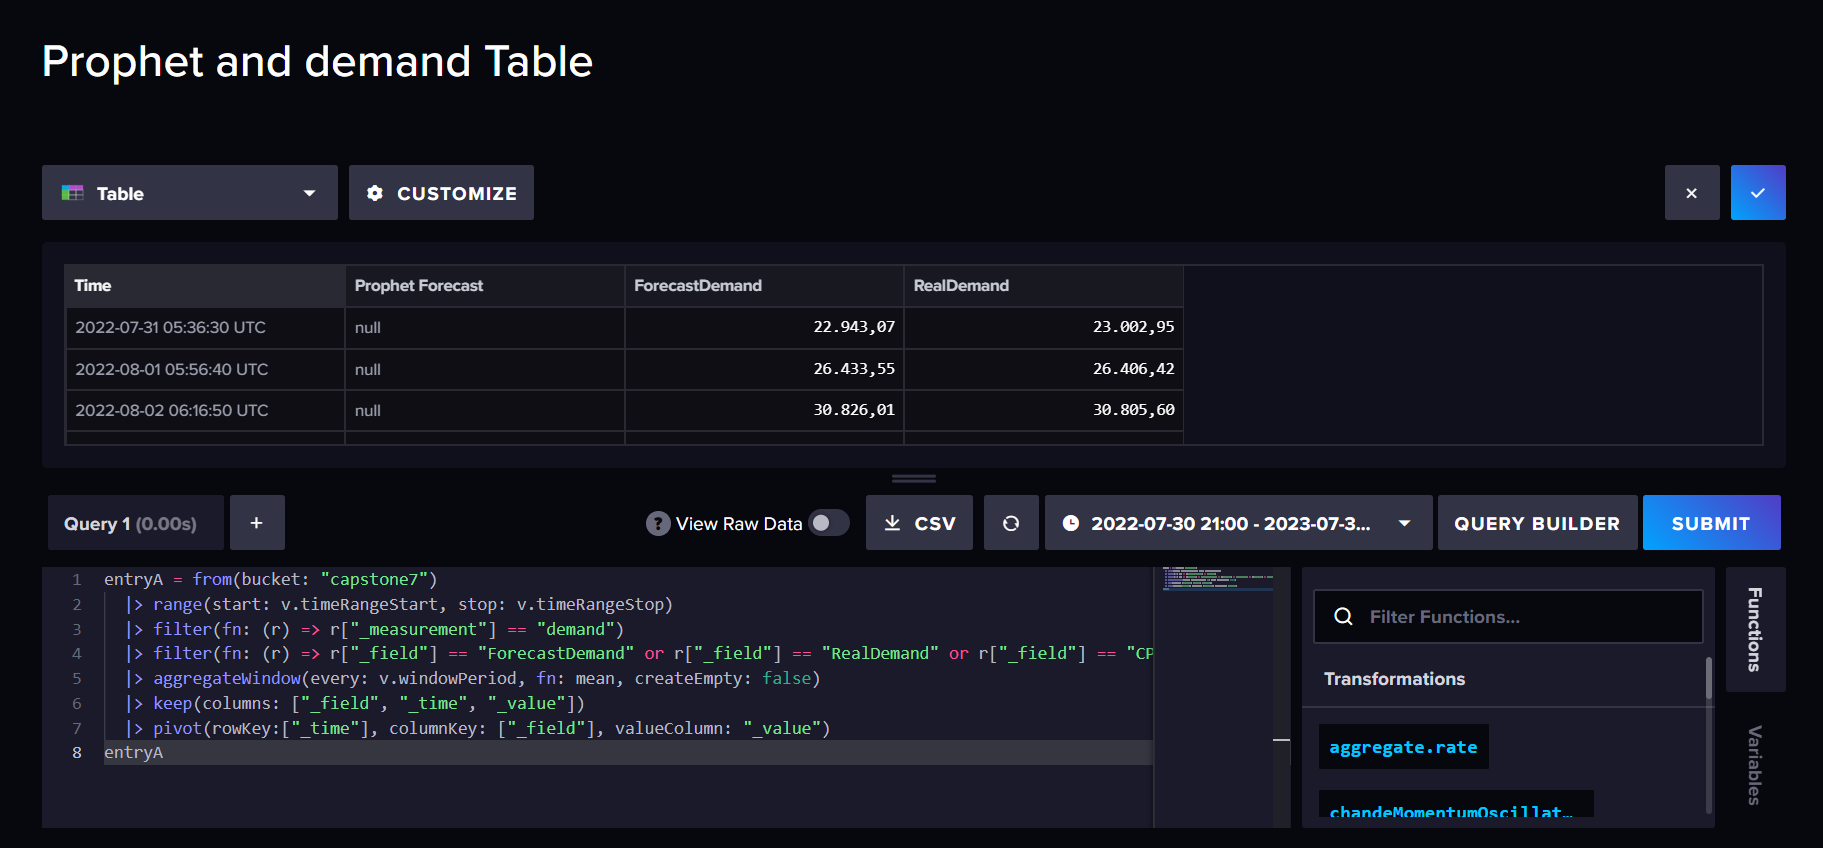
Code used to generate the first Gauge:
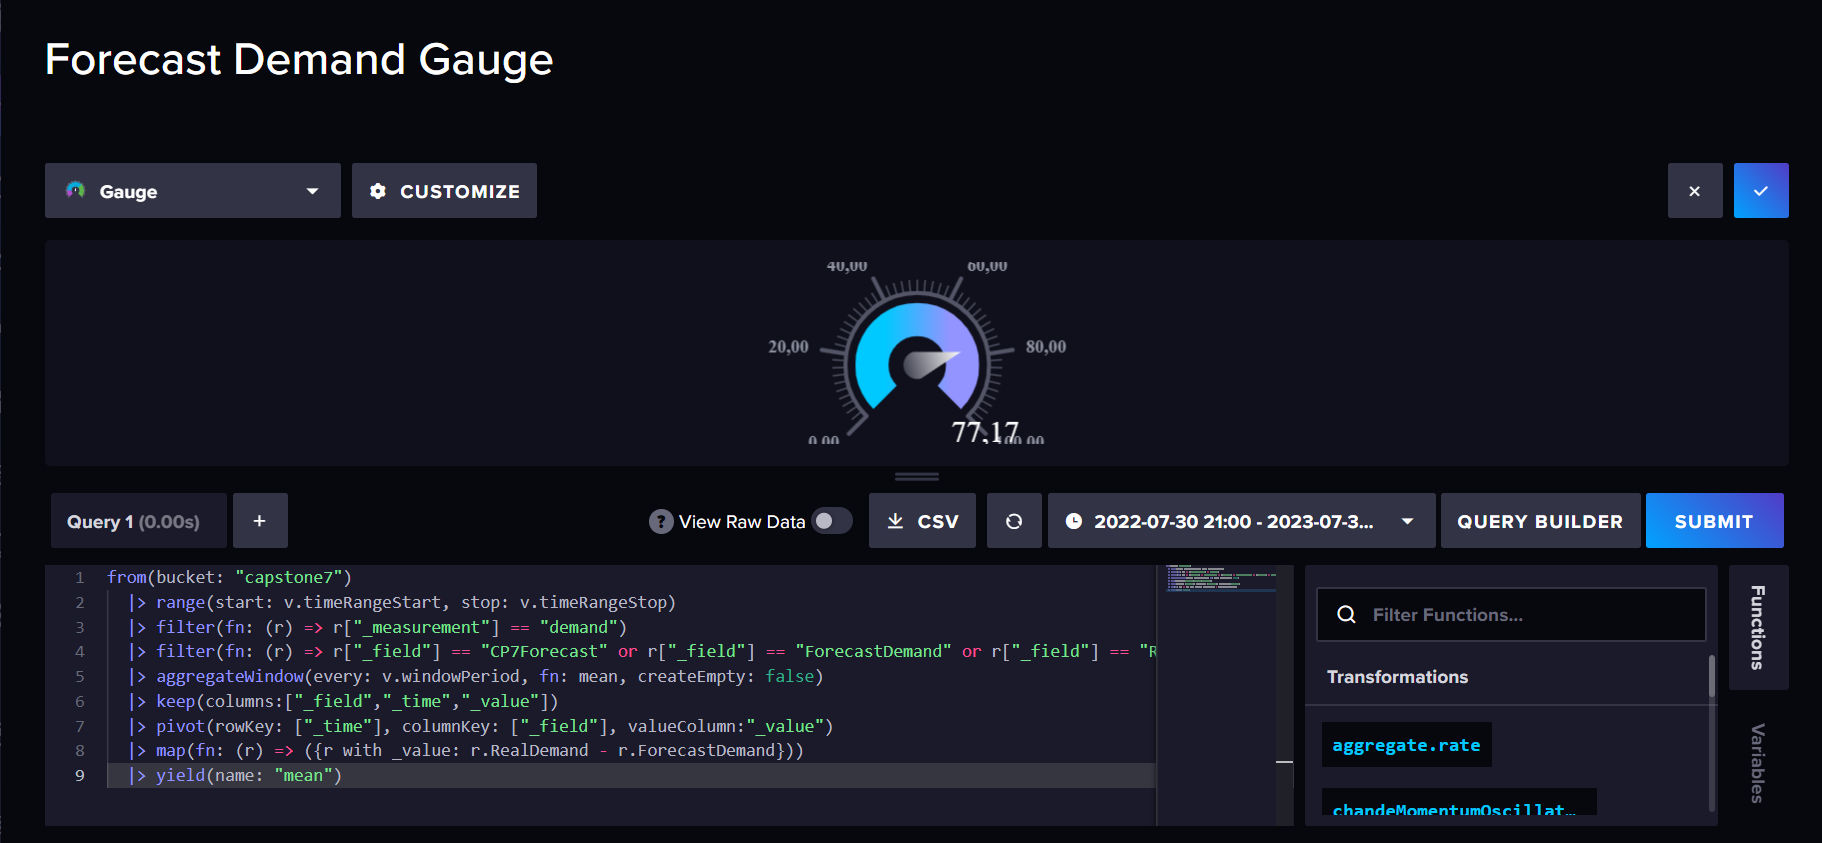
Code used to generate the first Gauge:
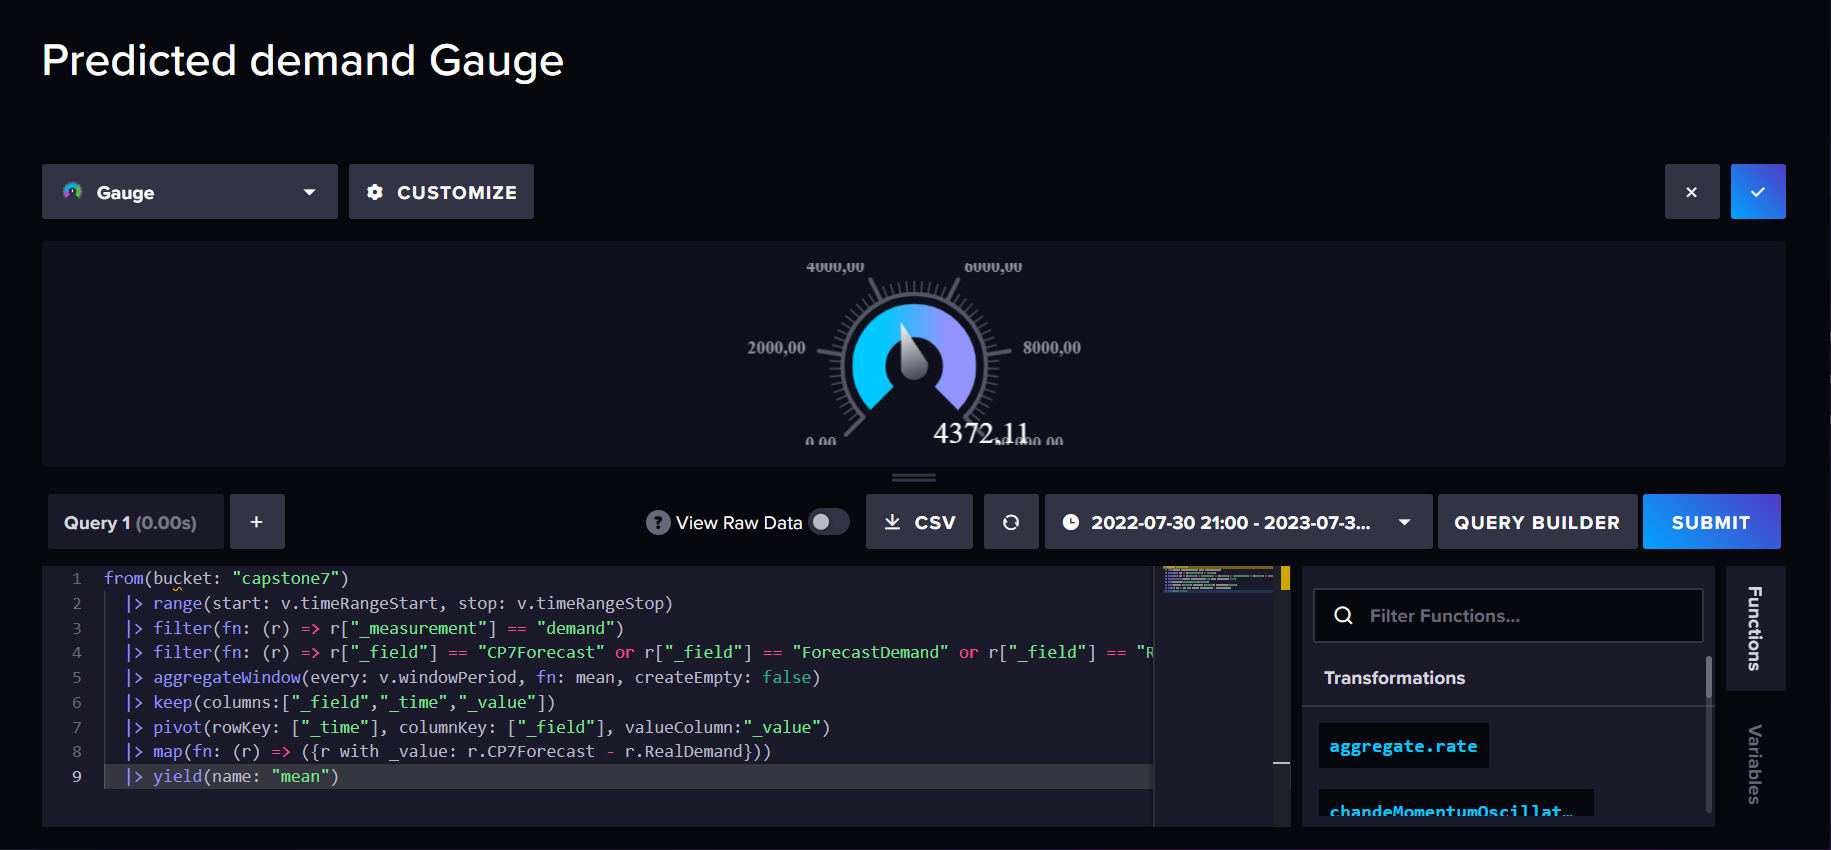

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

--- 